# 05 Overall Data Cleaning, Preprocessing, EDA & Modelling

## Libraries & Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

In [2]:
# import cleaned datasets/ original Kaggle datasets 
train = pd.read_csv("../assets/train.csv")

In [3]:
# No missing values in train data 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [4]:
# drop multiple columns containing address information as they are duplicated info within the dataframe
train.drop(["Address", "Block", "Street", "AddressAccuracy"], axis=1, inplace=True)

In [5]:
train.head(3)

Date                 Species  Trap  \
0  2007-05-29  CULEX PIPIENS/RESTUANS  T002   
1  2007-05-29          CULEX RESTUANS  T002   
2  2007-05-29          CULEX RESTUANS  T007   

              AddressNumberAndStreet   Latitude  Longitude  NumMosquitos  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991             1   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991             1   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279             1   

   WnvPresent  
0           0  
1           0  
2           0

In [6]:
train.shape

(10506, 8)

In [7]:
# check date range of our data
print("Earliest Record: ", train.Date.min())
print("Latest Record: ", train.Date.max())

Earliest Record:  2007-05-29
Latest Record:  2013-09-26


In [8]:
train.describe().T.round(3)

count    mean     std     min     25%     50%     75%     max
Latitude      10506.0  41.841   0.113  41.645  41.733  41.846  41.955  42.017
Longitude     10506.0 -87.700   0.097 -87.931 -87.760 -87.695 -87.628 -87.532
NumMosquitos  10506.0  12.854  16.134   1.000   2.000   5.000  17.000  50.000
WnvPresent    10506.0   0.052   0.223   0.000   0.000   0.000   0.000   1.000

## A. Feature Engineering, Data Merger & EDA

### 1. Feature Engineering for Time Variables

In [9]:
#convert date to datetime
train['Date'] = pd.to_datetime(train['Date'])

In [10]:
#create month, week and year columns to help with prelim EDA 
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
train['Year'] = train['Date'].dt.year
train['Year Month'] = train['Date'].dt.strftime('%Y %m')

### Occurences of the West Nile Virus (WNV) peaks in August every year. 

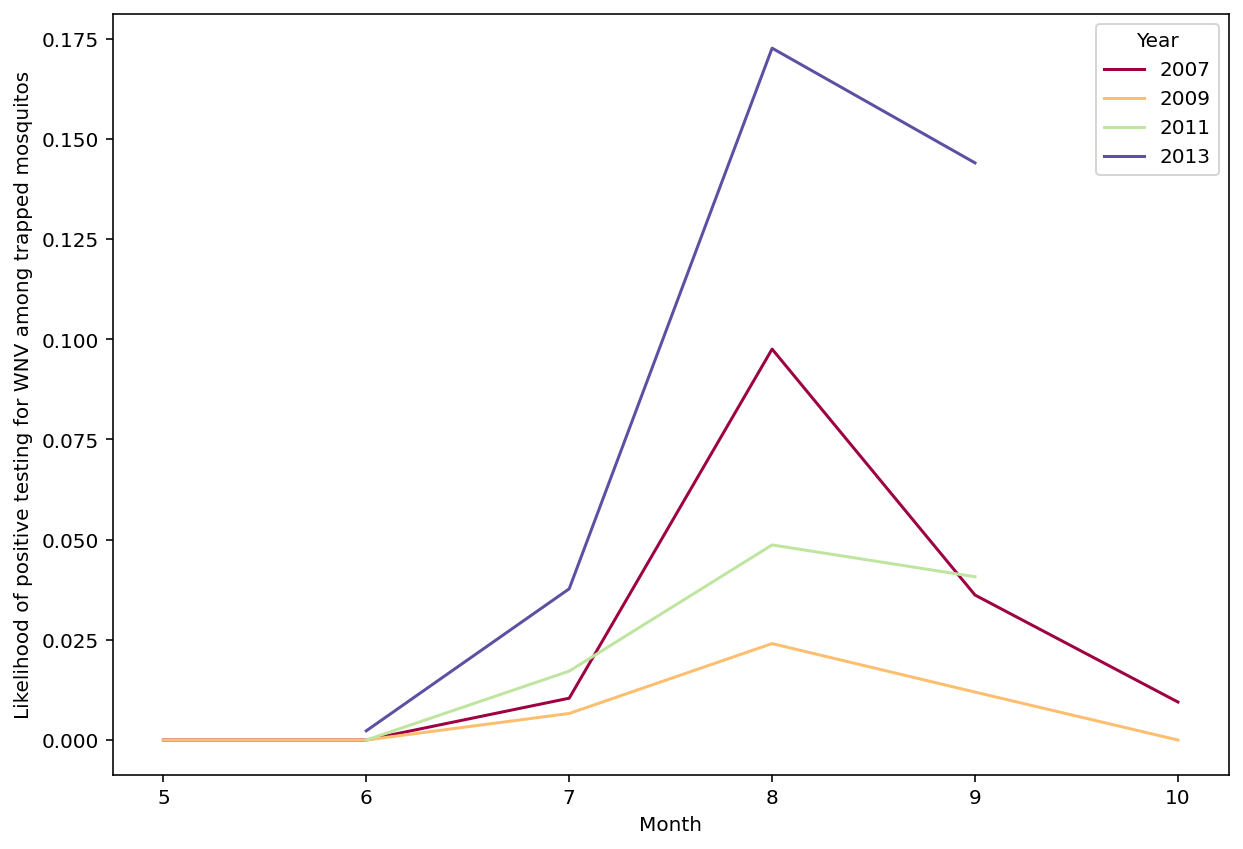

In [11]:
#plot WNV occurrences by month and year
plt.subplots(figsize=(10,7))
sns.lineplot(x='Month', y='WnvPresent', hue='Year', data=train, ci = None, palette = 'Spectral')
plt.ylabel("Likelihood of positive testing for WNV among trapped mosquitos")
plt.show()

### The WNV incidences were highest in August and this corresponds with the highest number of mosquitos collected for testing (likely a result of larger mosquito population sizes in certain months).

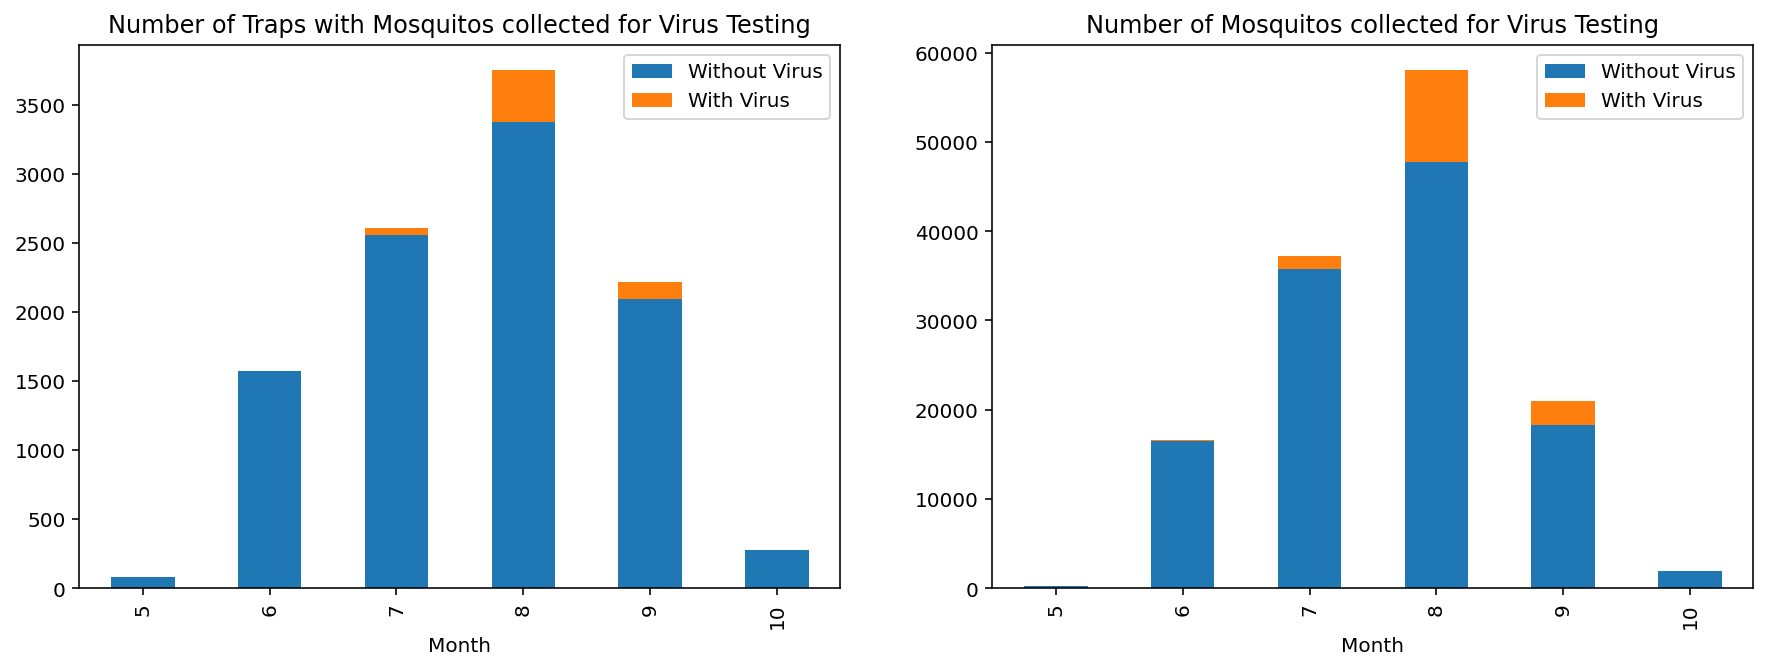

In [12]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = train.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = train.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Month")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Month")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

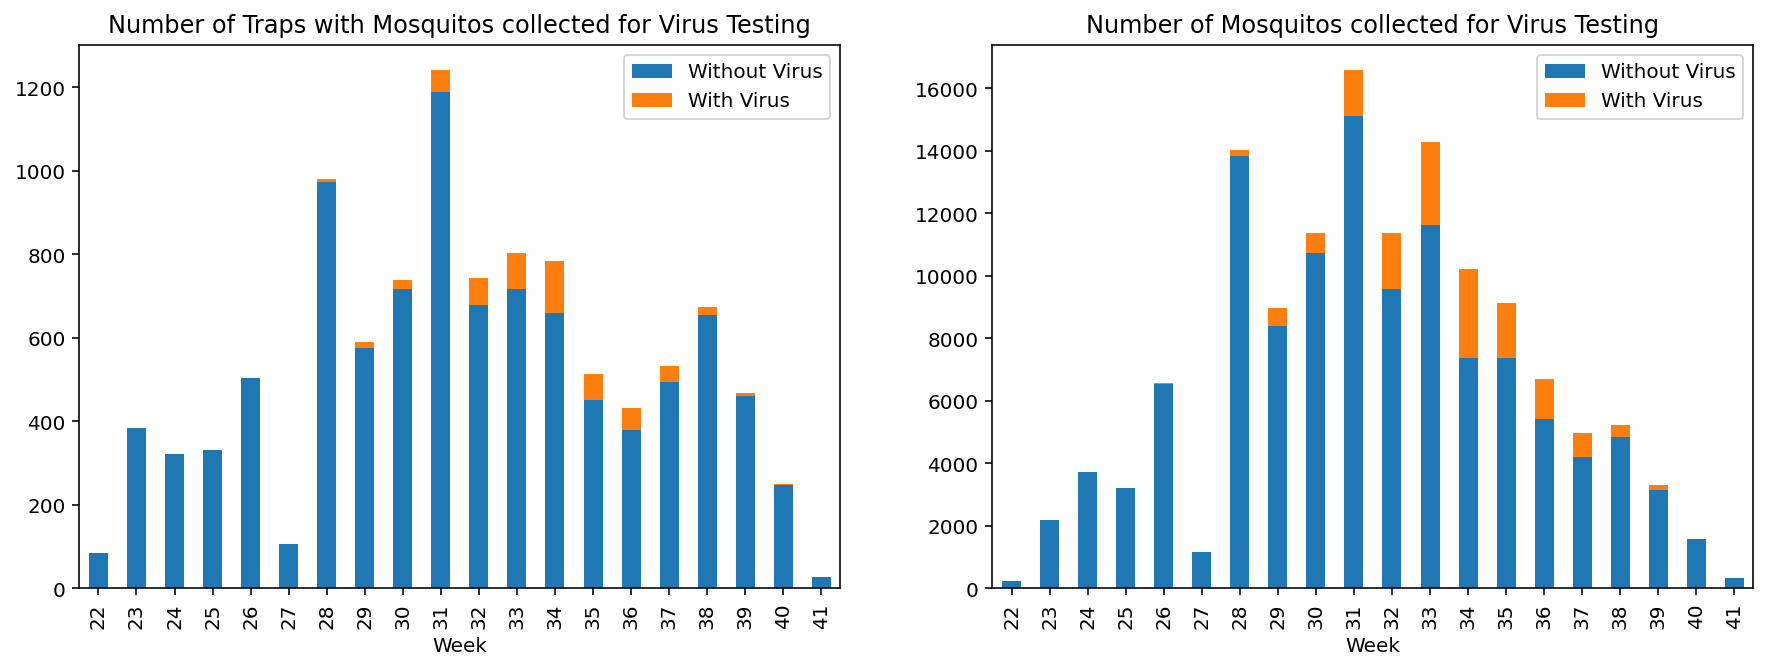

In [13]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = train.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = train.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Week")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Week")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

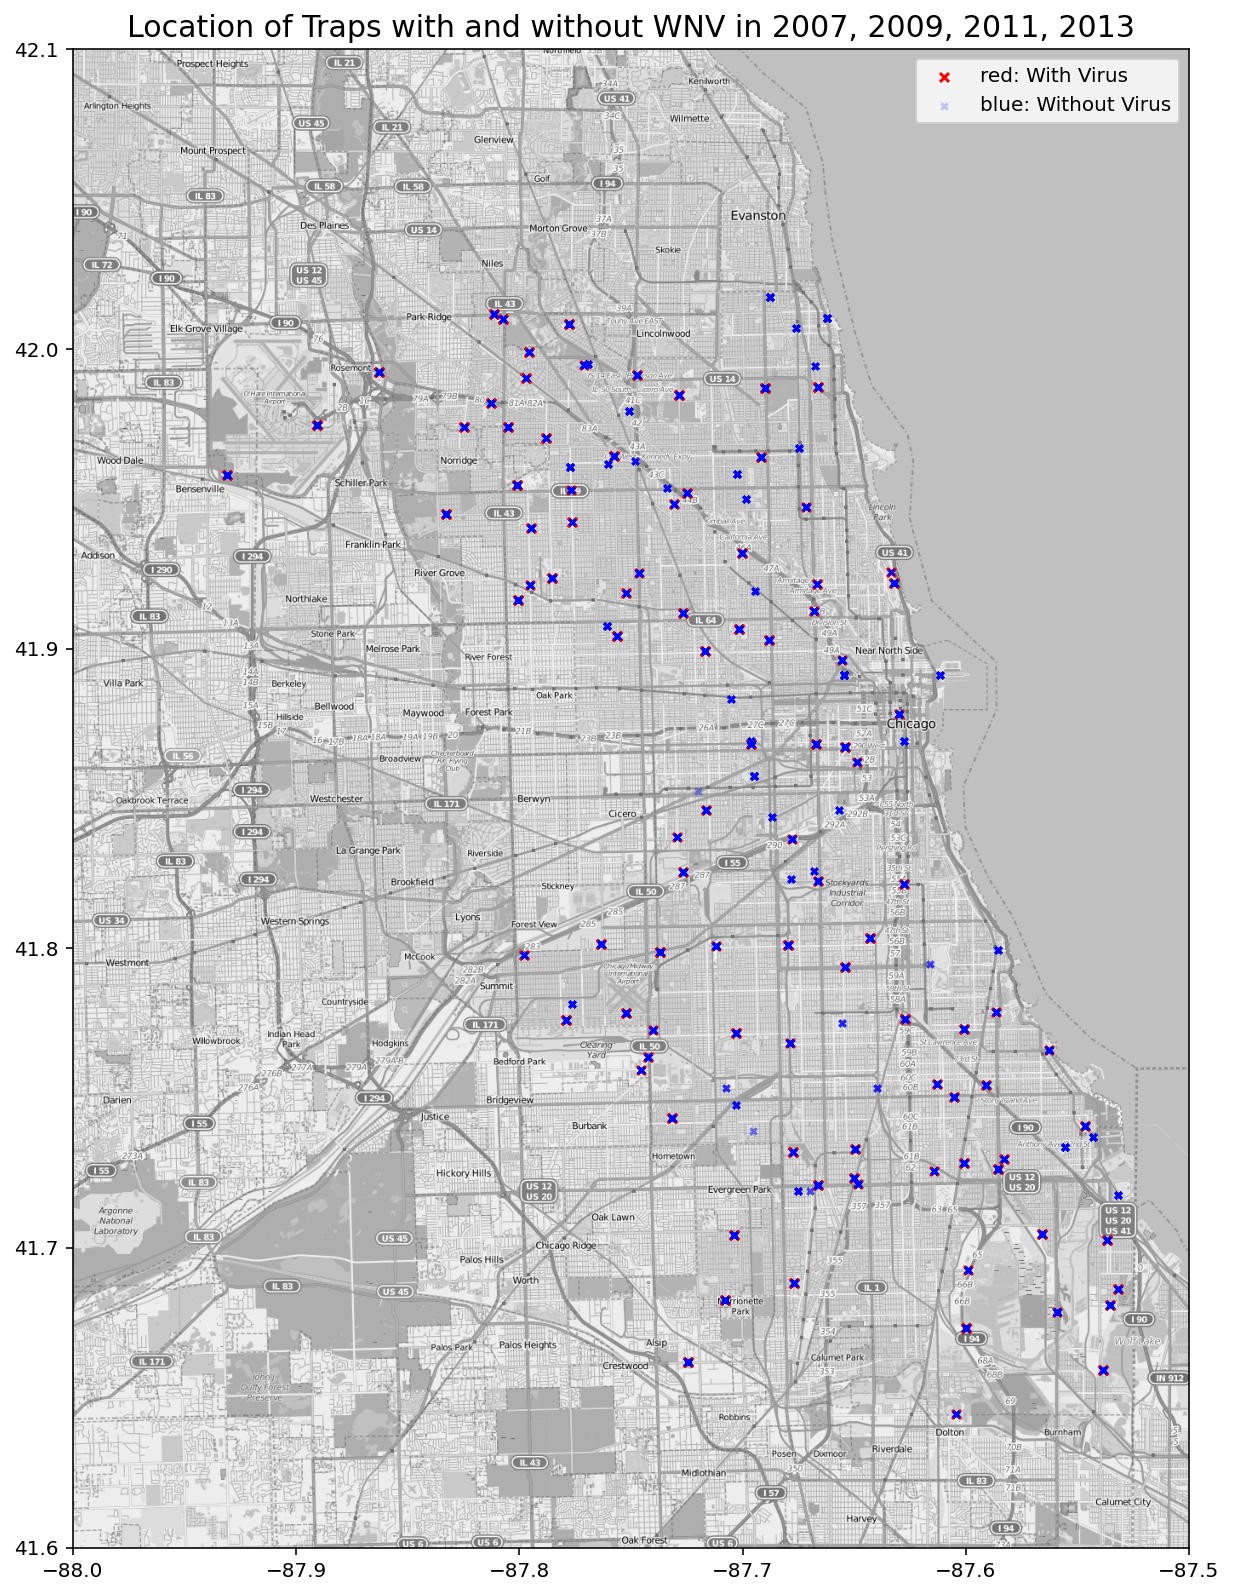

In [14]:
# plot locations of traps and instances of WNV cases
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


trap_wnv = train.loc[train["WnvPresent"]==1]
trap_clear = train.loc[train["WnvPresent"]==0]

wnv = plt.scatter(trap_wnv['Longitude'], trap_wnv['Latitude'], c="red", marker='x', s=20, alpha=1)
clear = plt.scatter(trap_clear['Longitude'], trap_clear['Latitude'], c="blue", marker='x', s=10, alpha=0.2)

plt.title("Location of Traps with and without WNV in 2007, 2009, 2011, 2013", fontsize=15)
plt.legend((wnv, clear), ("red: With Virus", "blue: Without Virus"));

### 2. Feature Engineering for Mosquito Species

### Of all the mosquitoes collected, only those belonging to species groups - `Restuans` or `Pipiens` - had tested positive for the virus in the train dataset.

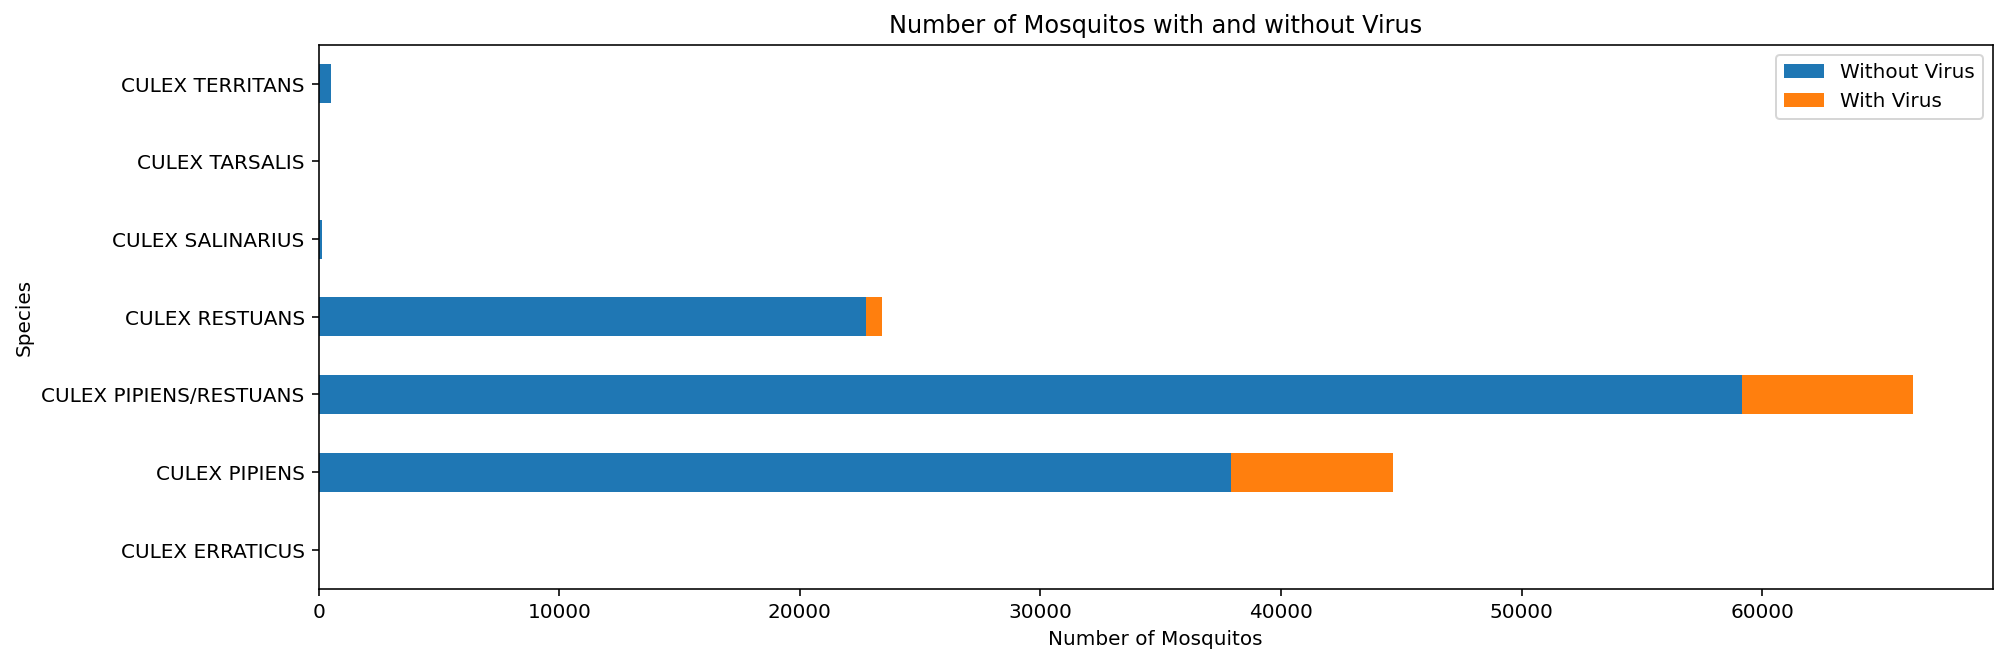

In [15]:
species_with_virus = train.pivot_table(values=['NumMosquitos'], index='Species',
                                       columns='WnvPresent', aggfunc='sum')

species_with_virus.plot(kind='barh', stacked=True, figsize=(15,5))
plt.title("Number of Mosquitos with and without Virus")
plt.xlabel("Number of Mosquitos")
plt.legend(labels=["Without Virus", "With Virus"]);

### Mosquito Species will likely be a useful predictor. We proceed to dummify it.

In [16]:
# print unique species 
train["Species"].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [17]:
species = ["PIPIENS", "RESTUANS"]

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
for i in species:
    train[i] = 0
    for index, row in train.iterrows():
        if i in row["Species"]:
            train[i][index] = 1 

<ipython-input-17-277c31943e34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i][index] = 1


In [18]:
# drop species column as data has already been stored in dummified variables
train.drop("Species", axis=1, inplace=True)
train.head()

Date  Trap             AddressNumberAndStreet   Latitude  Longitude  \
0 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2 2007-05-29  T007   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Month  Week  Year Year Month  PIPIENS  RESTUANS  
0             1           0      5    22  2007    2007 05        1         1  
1             1           0      5    22  2007    2007 05        0         1  
2             1           0      5    22  2007    2007 05        0         1  
3             1           0      5    22  2007    2007 05        1         1  
4             4           0      5    22  2007    2007 05        0         1

### 3. Feature Engineering - Virus Risk
Risk levels computed based on Occurences of WNV in the past at the respective addresses:
- `Very low`: Between 0 and 2 cases of WNV detected
- `Low`: Between 2 and 6 cases
- `Medium`: Between 6 and 10 cases
- `High`: More than 10 cases

In [19]:
# create a pivot table to sum the number of WNV cases detected at each location
wnv_risk = train.pivot_table(values=['WnvPresent'], index='AddressNumberAndStreet', aggfunc='sum')
wnv_risk.describe().T.round()

count  mean  std  min  25%  50%  75%   max
WnvPresent  138.0   4.0  7.0  0.0  0.0  2.0  6.0  66.0

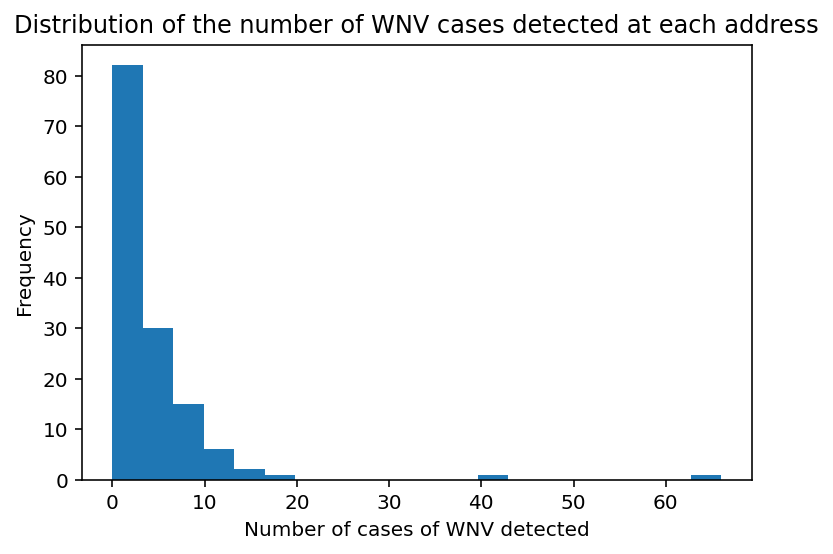

In [20]:
# plot histogram to show the spread in number of WNV cases detected 
plt.title("Distribution of the number of WNV cases detected at each address")
plt.ylabel("Frequency")
plt.xlabel("Number of cases of WNV detected")
plt.hist(wnv_risk, bins=20);

In [21]:
# create feature to assign location risk of WNV
wnv_risk['WNV_risk'] = pd.cut(wnv_risk["WnvPresent"], bins=[0, 2, 6, 10, 100], right=False, labels=['very low', 'low', 'medium', 'high'], ordered=True)
wnv_risk.head()

WnvPresent  WNV_risk
AddressNumberAndStreet                                     
1000  E 67TH ST, Chicago, IL                    4       low
1000  N CENTRAL PARK DR, Chicago, IL            8    medium
1000  S CALIFORNIA AVE, Chicago, IL             0  very low
1000  S COTTAGE GROVE, Chicago, IL              2       low
1000  S STONY ISLAND AVE, Chicago, IL          16      high

In [22]:
# merge risk data with train data, dummify the categorical variable and drop original
train_merged_df = train.merge(wnv_risk[["WNV_risk"]], how="left", on="AddressNumberAndStreet")
train_merged_df = pd.concat([train_merged_df, pd.get_dummies(train_merged_df["WNV_risk"], prefix="WnvRisk")], axis=1)
train_merged_df.drop(["WNV_risk"], axis=1, inplace=True)

### 4. Merger of Train data with Weather data

In order to merge both the train and weather data, we first need to label the traps based on their proximity to either one of the weather stations. This assignment will allow us to merge and retrieve the weather data for the respective traps. If a trap is located closer to Chicago Midway International Airport than the Chicago O'Hare International Airport, it will be tagged as `Station` = 2, and =1 if otherwise. 

In [23]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

# create function to assign observation based on latitude and longitude to either stations
def assign_station(lat:int, lng:int):
    coord_stn1 = (41.995, -87.933)
    coord_stn2 = (41.786, -87.752)
    coord_curr = (lat, lng)
    return 1 if geodesic(coord_curr, coord_stn1) < geodesic(coord_curr, coord_stn2) else 2

In [24]:
# apply the function to create the assignment of observation to weather stations 
train_merged_df['Station'] = train_merged_df.apply(lambda x: assign_station(x['Latitude'], x['Longitude']), axis=1)

In [25]:
# 69% of the traps are located closer to the Chicago Midway International Airport in the train data
train_merged_df["Station"].value_counts(normalize=True)

2    0.686084
1    0.313916
Name: Station, dtype: float64

In [26]:
# import cleaned weather datasets
weather = pd.read_csv("../assets/weather_cleaned.csv")
weather.head()

Station        Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
0        1  2007-05-01    83    50  66.5        51          0.0        29.10   
1        2  2007-05-01    84    52  68.0        51          0.0        29.18   
2        1  2007-05-02    59    42  50.5        42          0.0        29.38   
3        2  2007-05-02    60    43  51.5        42          0.0        29.44   
4        1  2007-05-03    66    46  56.0        40          0.0        29.39   

   SeaLevel  AvgSpeed  Rain  Mist  RelativeHumidity  
0     29.82       9.2     0     0         57.394895  
1     29.82       9.6     0     0         54.497276  
2     30.09      13.4     0     1         72.508686  
3     30.08      13.4     0     1         69.872482  
4     30.12      11.9     0     0         54.848860

In [27]:
# save weather's Data as pd's datetime format to ensure consistency in data format across different dataframes 
weather['Date'] = pd.to_datetime(weather['Date'])

In [28]:
# merge data 
train_merged_df = train_merged_df.merge(weather, how="left", on=["Station", "Date"])
train_merged_df.head()

Date  Trap             AddressNumberAndStreet   Latitude  Longitude  \
0 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2 2007-05-29  T007   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Month  Week  Year  ... Tmin  Tavg  DewPoint  \
0             1           0      5    22  2007  ...   60  74.0        58   
1             1           0      5    22  2007  ...   60  74.0        58   
2             1           0      5    22  2007  ...   60  74.0        58   
3             1           0      5    22  2007  ...   60  74.0        58   
4             4           0      5    22  2007  ...   60  74.0        58   

   PrecipTotal  StnPressure  SeaLevel  AvgSpeed  Rain  Mist  RelativeHumidity  
0          0.0        29.39     30.11       6.5     0     1         57.368792  
1          0.0        29.39     30.11       6.5     0     1         57.368792  
2          0.0        29.39     30.11       6.5     0     1         57.368792  
3          0.0        29.39     30.11       6.5     0     1         57.368792  
4          0.0        29.39     30.11       6.5     0     1         57.368792  

[5 rows x 29 columns]

In [29]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Trap                    10506 non-null  object        
 2   AddressNumberAndStreet  10506 non-null  object        
 3   Latitude                10506 non-null  float64       
 4   Longitude               10506 non-null  float64       
 5   NumMosquitos            10506 non-null  int64         
 6   WnvPresent              10506 non-null  int64         
 7   Month                   10506 non-null  int64         
 8   Week                    10506 non-null  UInt32        
 9   Year                    10506 non-null  int64         
 10  Year Month              10506 non-null  object        
 11  PIPIENS                 10506 non-null  int64         
 12  RESTUANS                10506 non-null  int64 

### Based on the heatmaps below, the existing features seem to have low correlation with the target. 

In [30]:
# create a temporary dataframe and drop categorical data and variables that are not present in test set
df = train_merged_df.drop(["Date", "Station", "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Year", "Trap"], axis=1)

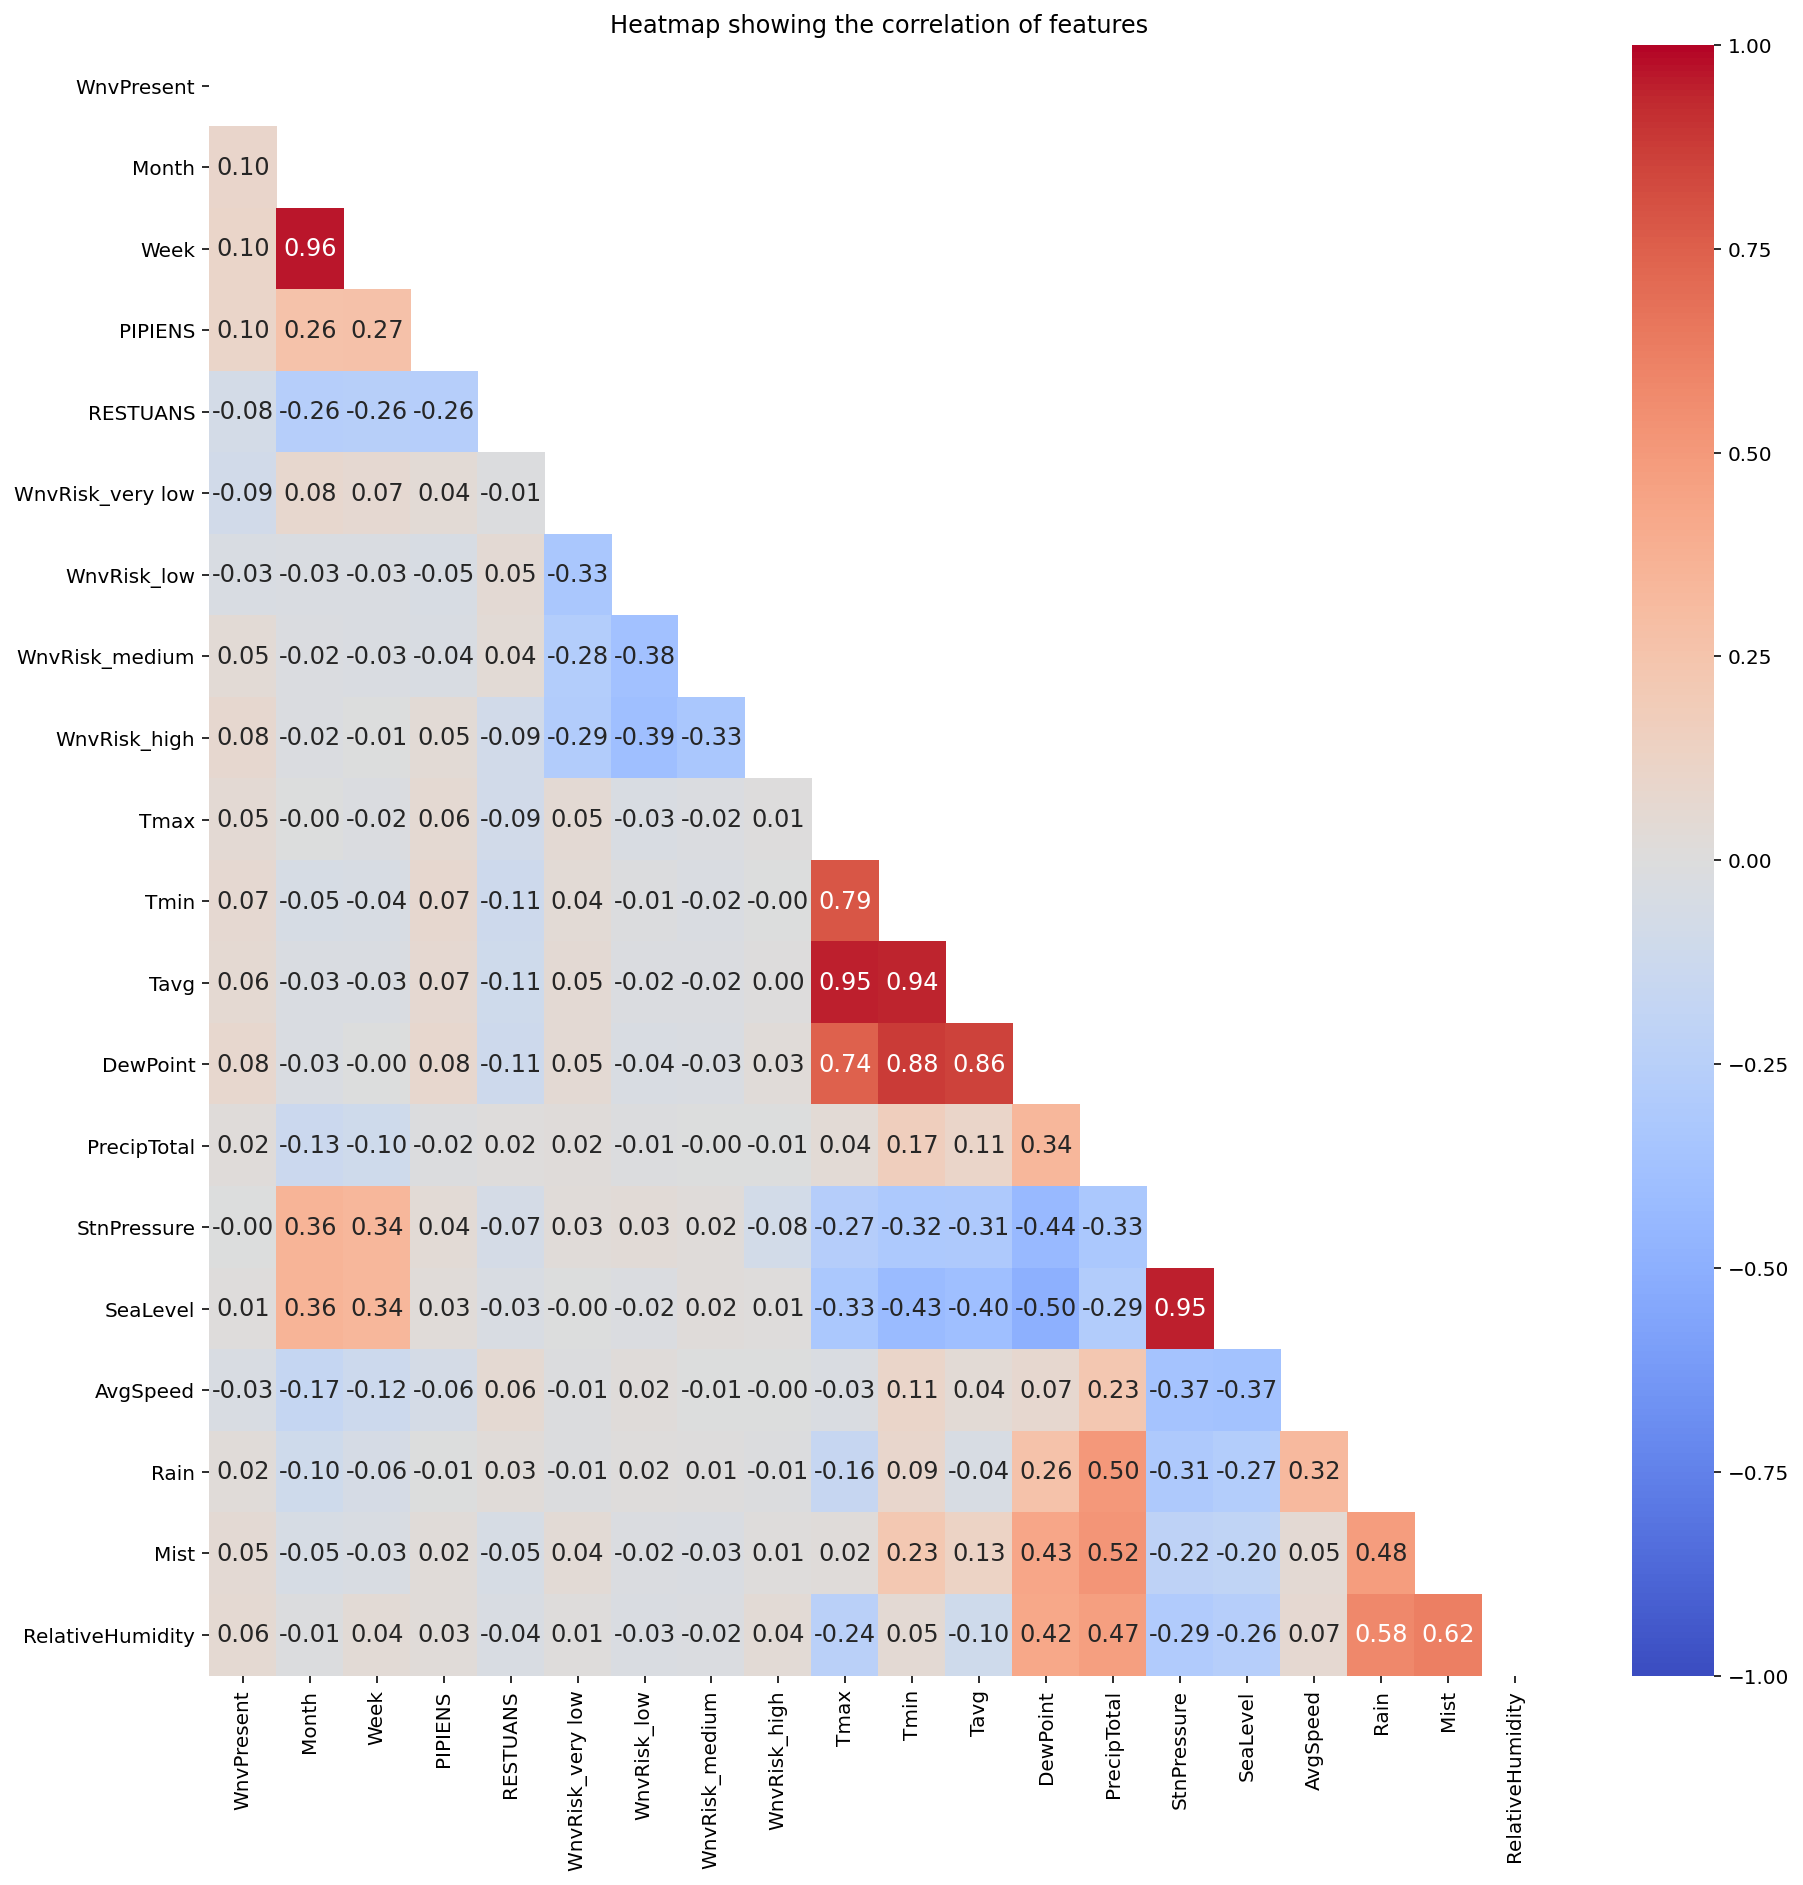

In [31]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,15))
plt.title("Heatmap showing the correlation of features")
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

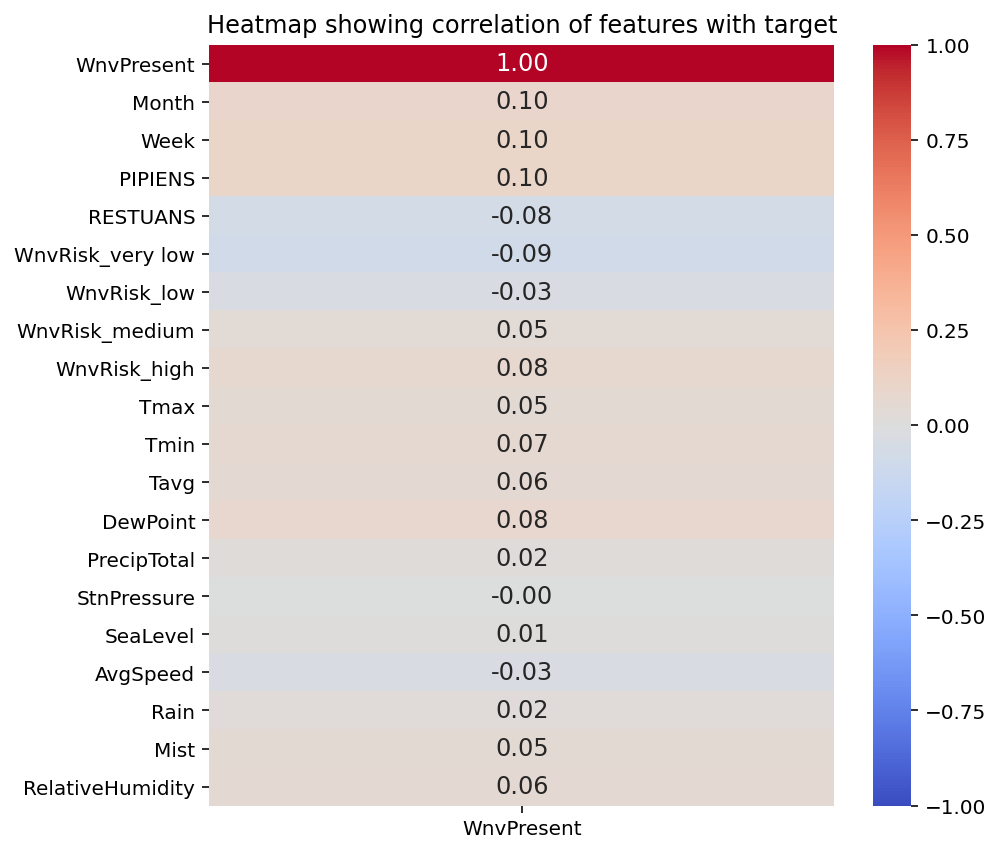

In [32]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(df.corr()[["WnvPresent"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [33]:
# drop data not required for modelling
train_merged_df.drop([ "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Year", "Trap"], axis=1, inplace=True)

In [34]:
train_merged_df.shape

(10506, 23)

In [35]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              10506 non-null  datetime64[ns]
 1   WnvPresent        10506 non-null  int64         
 2   Month             10506 non-null  int64         
 3   Week              10506 non-null  UInt32        
 4   Year Month        10506 non-null  object        
 5   PIPIENS           10506 non-null  int64         
 6   RESTUANS          10506 non-null  int64         
 7   WnvRisk_very low  10506 non-null  uint8         
 8   WnvRisk_low       10506 non-null  uint8         
 9   WnvRisk_medium    10506 non-null  uint8         
 10  WnvRisk_high      10506 non-null  uint8         
 11  Station           10506 non-null  int64         
 12  Tmax              10506 non-null  int64         
 13  Tmin              10506 non-null  int64         
 14  Tavg              1050

### Having merged the train and weather datasets, let's explore further relationships across the variables.

In [36]:
# we create a function that allows us to examine how the variables change overtime based on time unit (e.g. Year_Month)
# this allows us to compare and see if the fluctuations in the weather are related to the incidences of virus

def trend(time_unit:str):
    # create pivot table to summarise changes in variable by selected date metric/ time unit
    df = pd.DataFrame(pd.pivot_table(data=train_merged_df, 
                                          index=time_unit, 
                                          values=['WnvPresent', 'Tmin', 'Tmax', 'Tavg', 
                                                  'DewPoint', 'PrecipTotal', 'SeaLevel', 'AvgSpeed'],
                                          aggfunc=np.mean).to_records())
    
    # plot the trends for comparison
    features = df.drop([time_unit,  'WnvPresent'],axis='columns').columns.tolist()
    for f in features:
        fig, axes = plt.subplots(nrows=2, ncols=1,  figsize=(15, 8), sharex=True)
        df.plot(x=time_unit, y= f , ax=axes[0], marker='o', title=f)
        df.plot(x=time_unit, y="WnvPresent", marker='o', ax=axes[1])
        groupby_list = df[time_unit].unique().tolist()
        plt.xticks(np.arange(len(groupby_list)), labels = groupby_list, rotation=45)

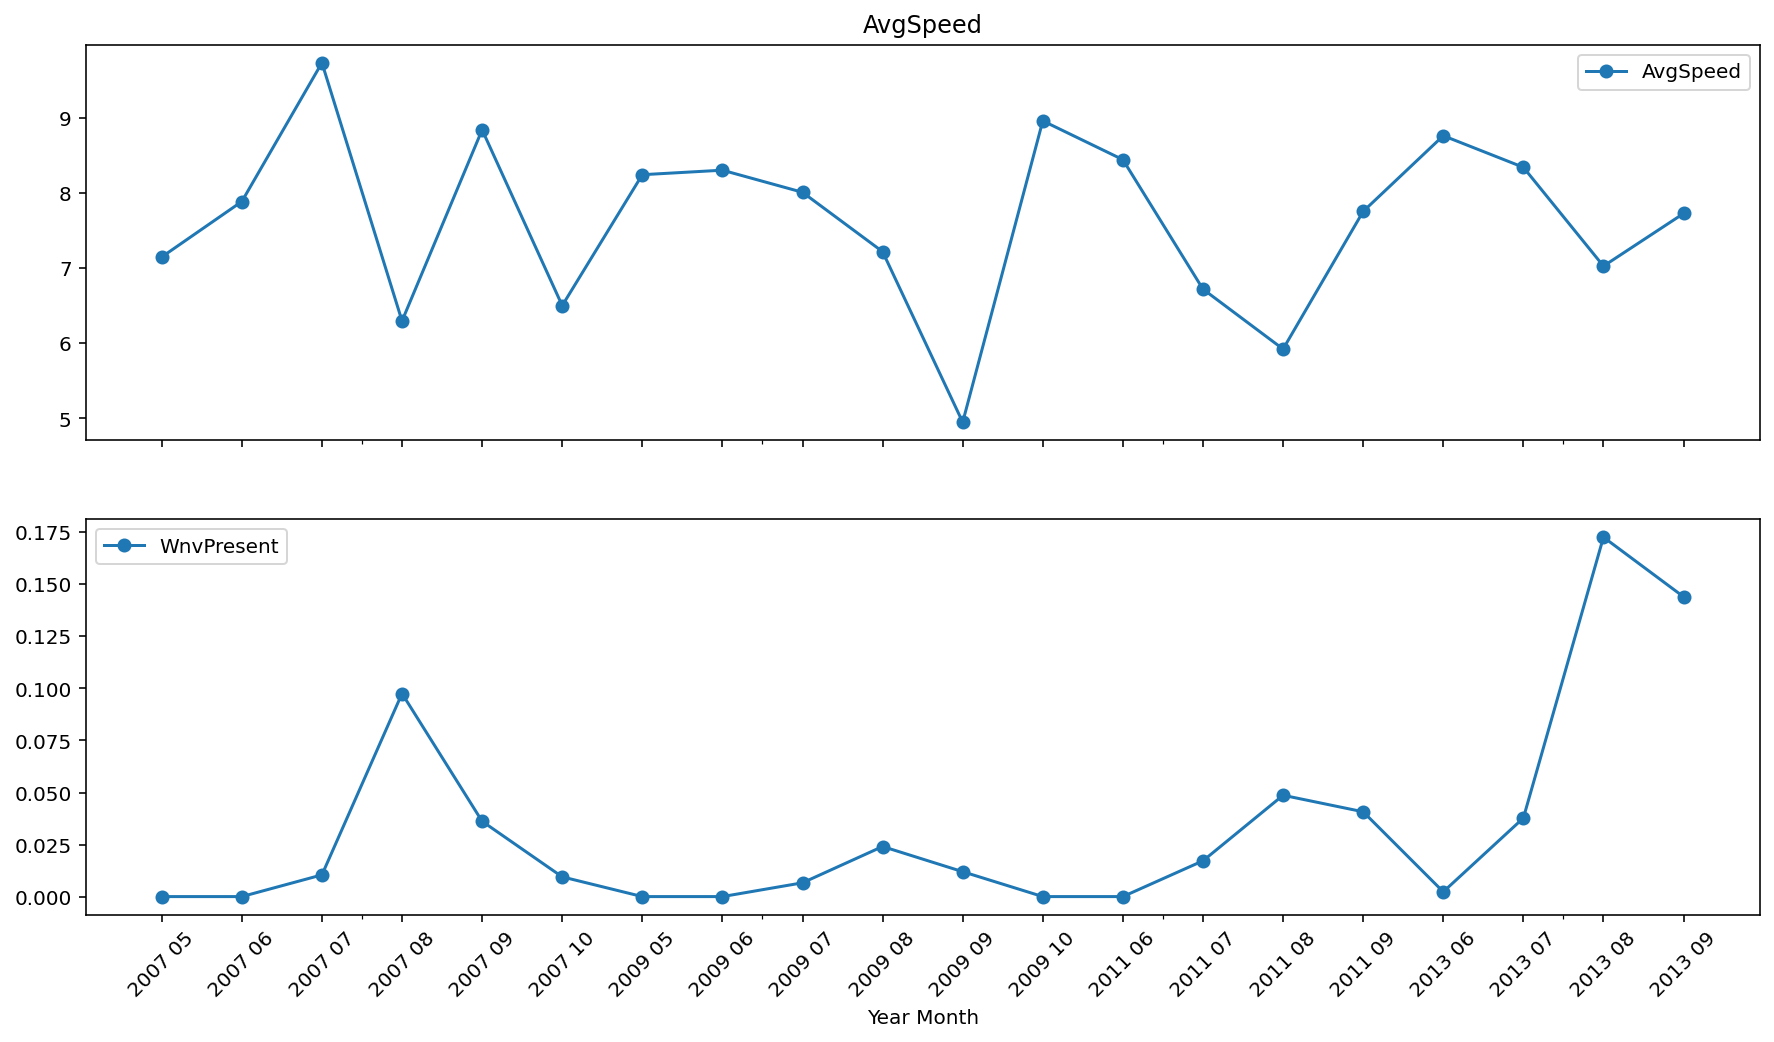

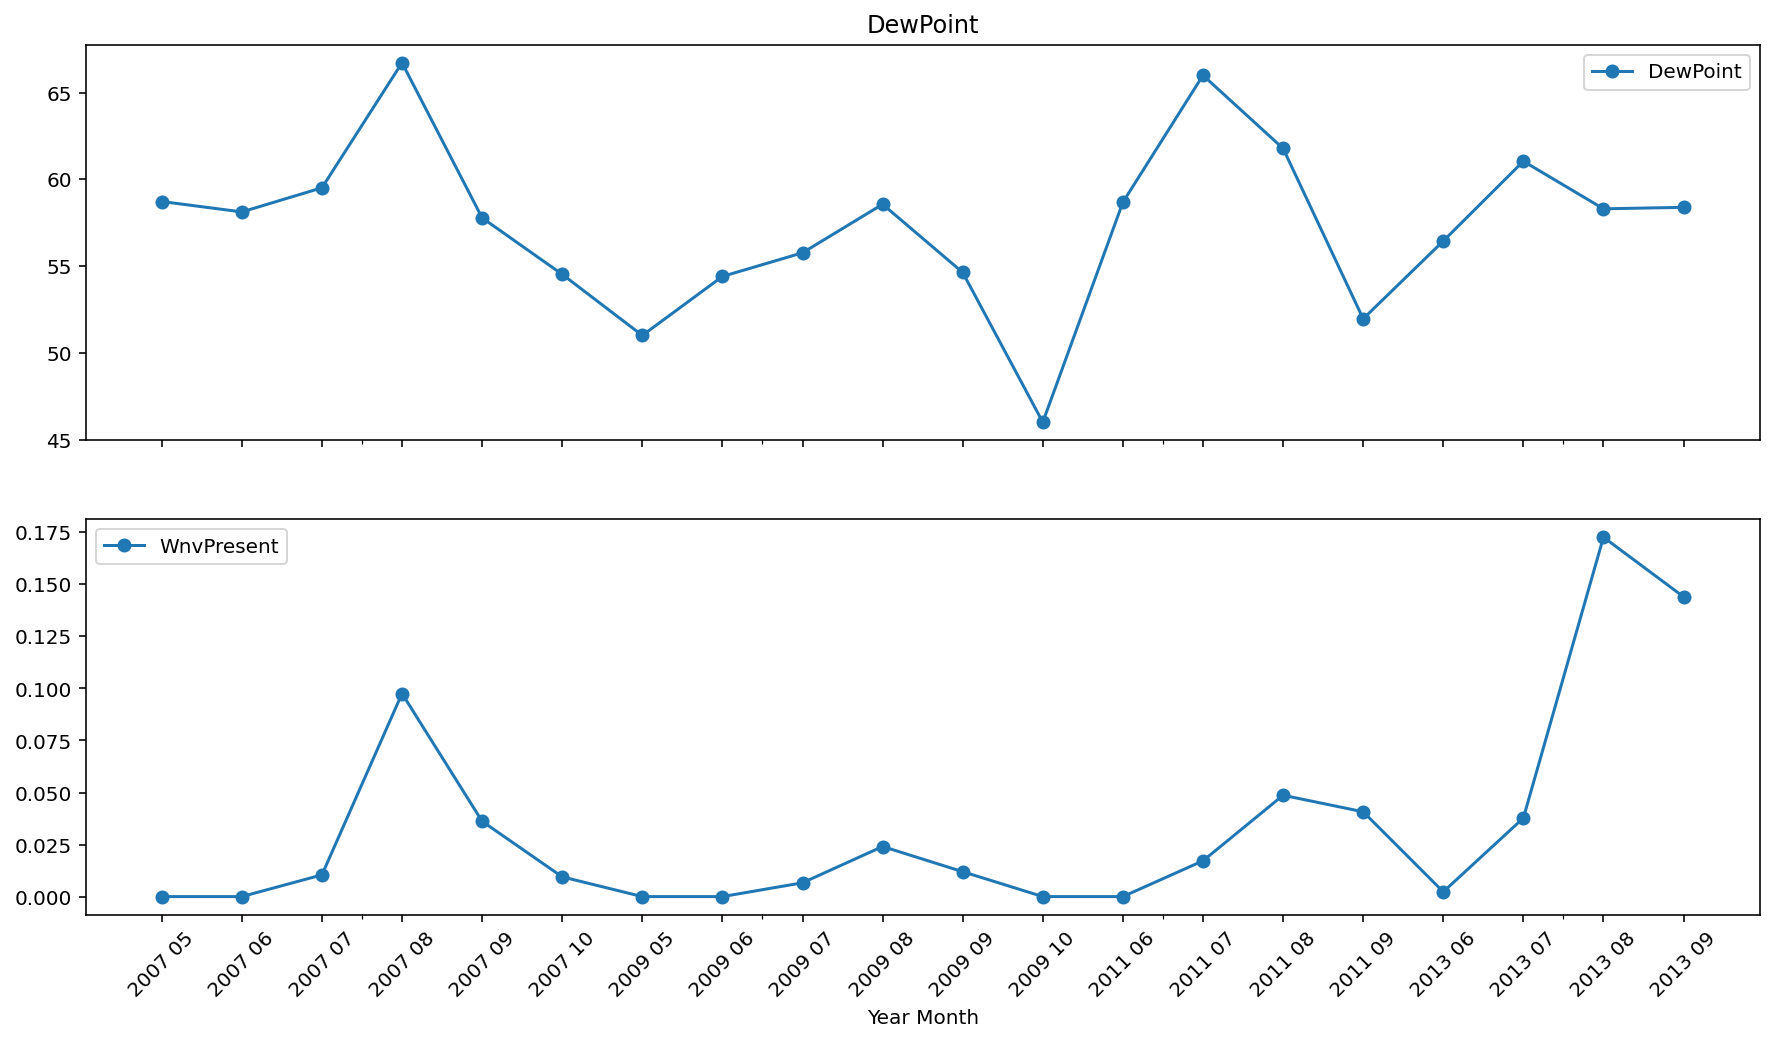

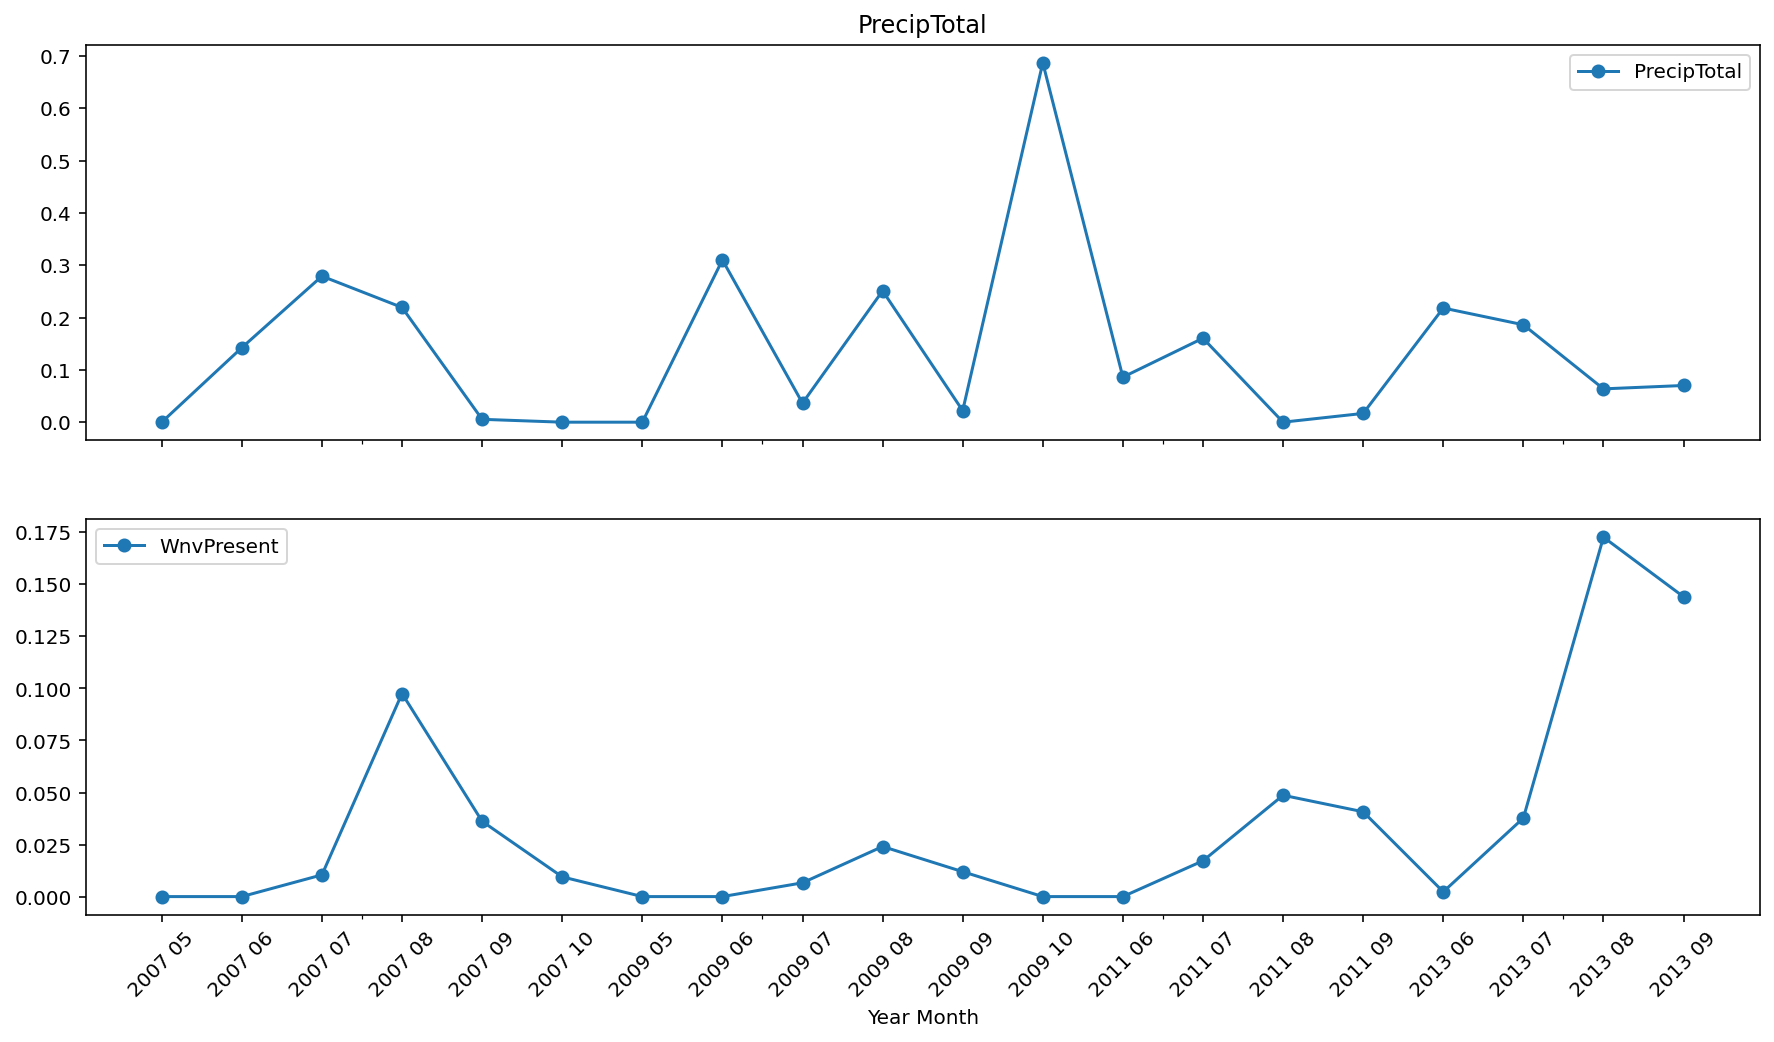

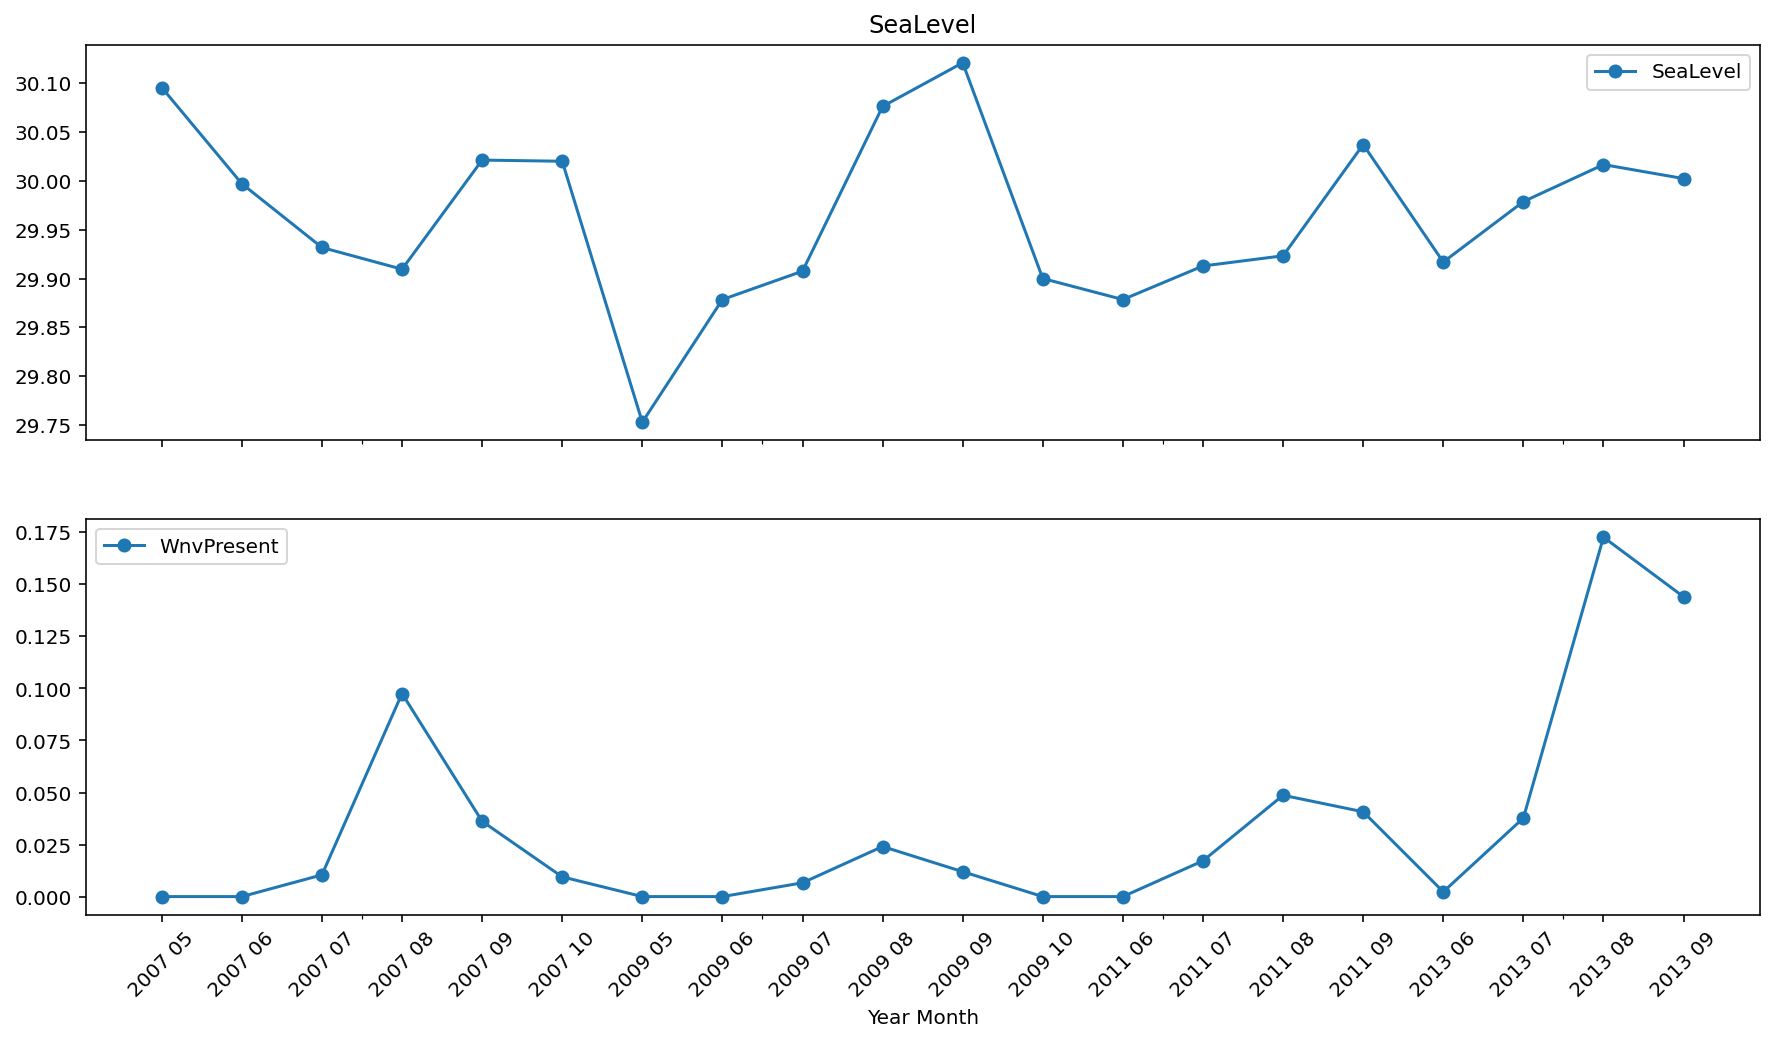

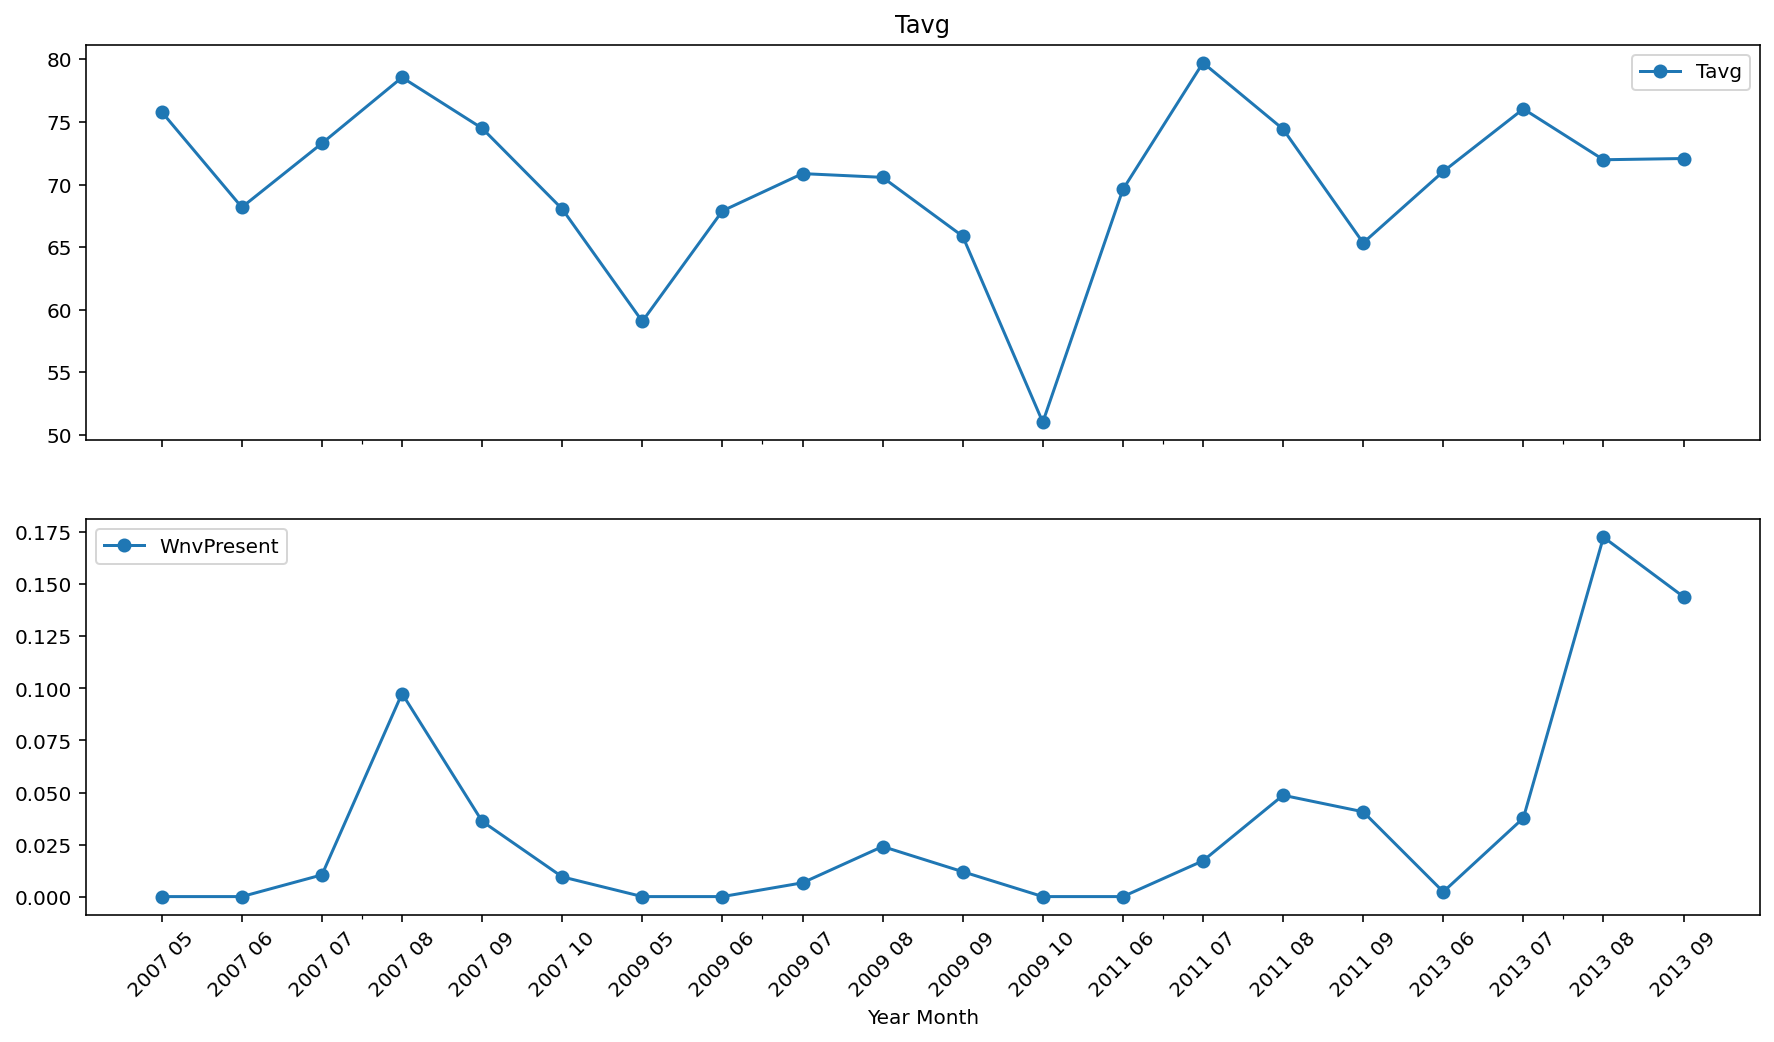

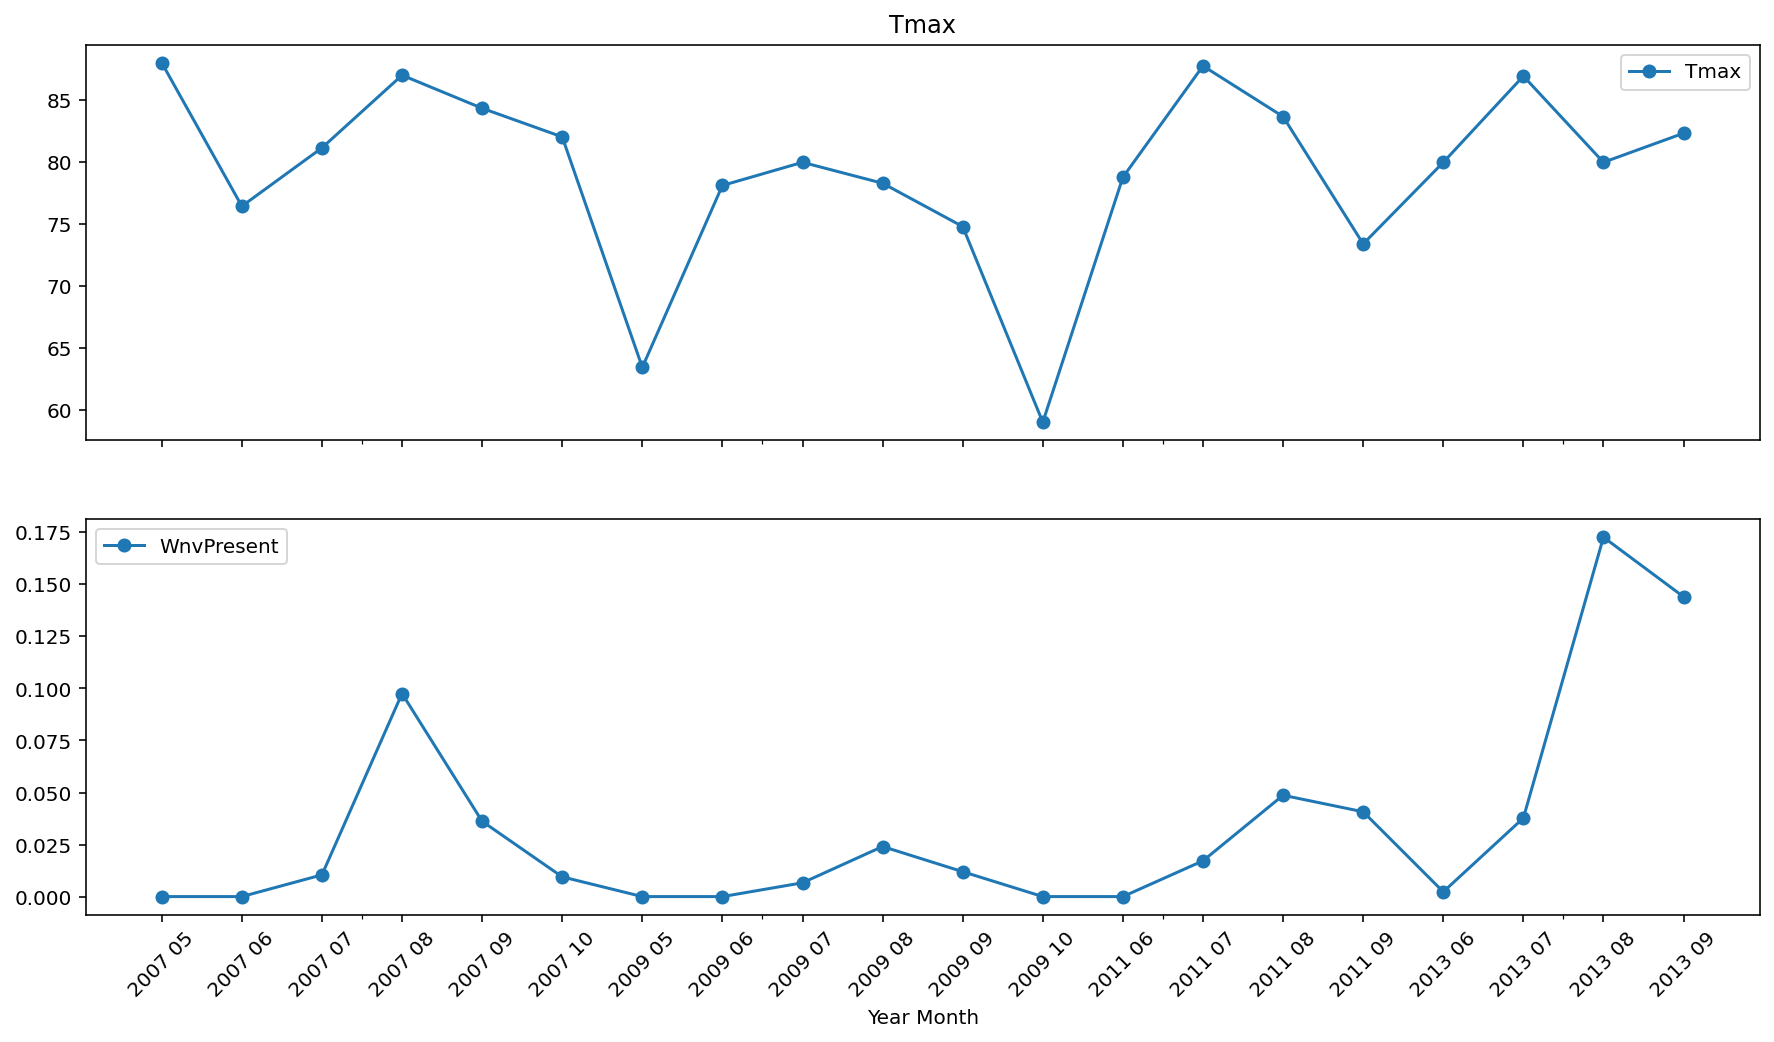

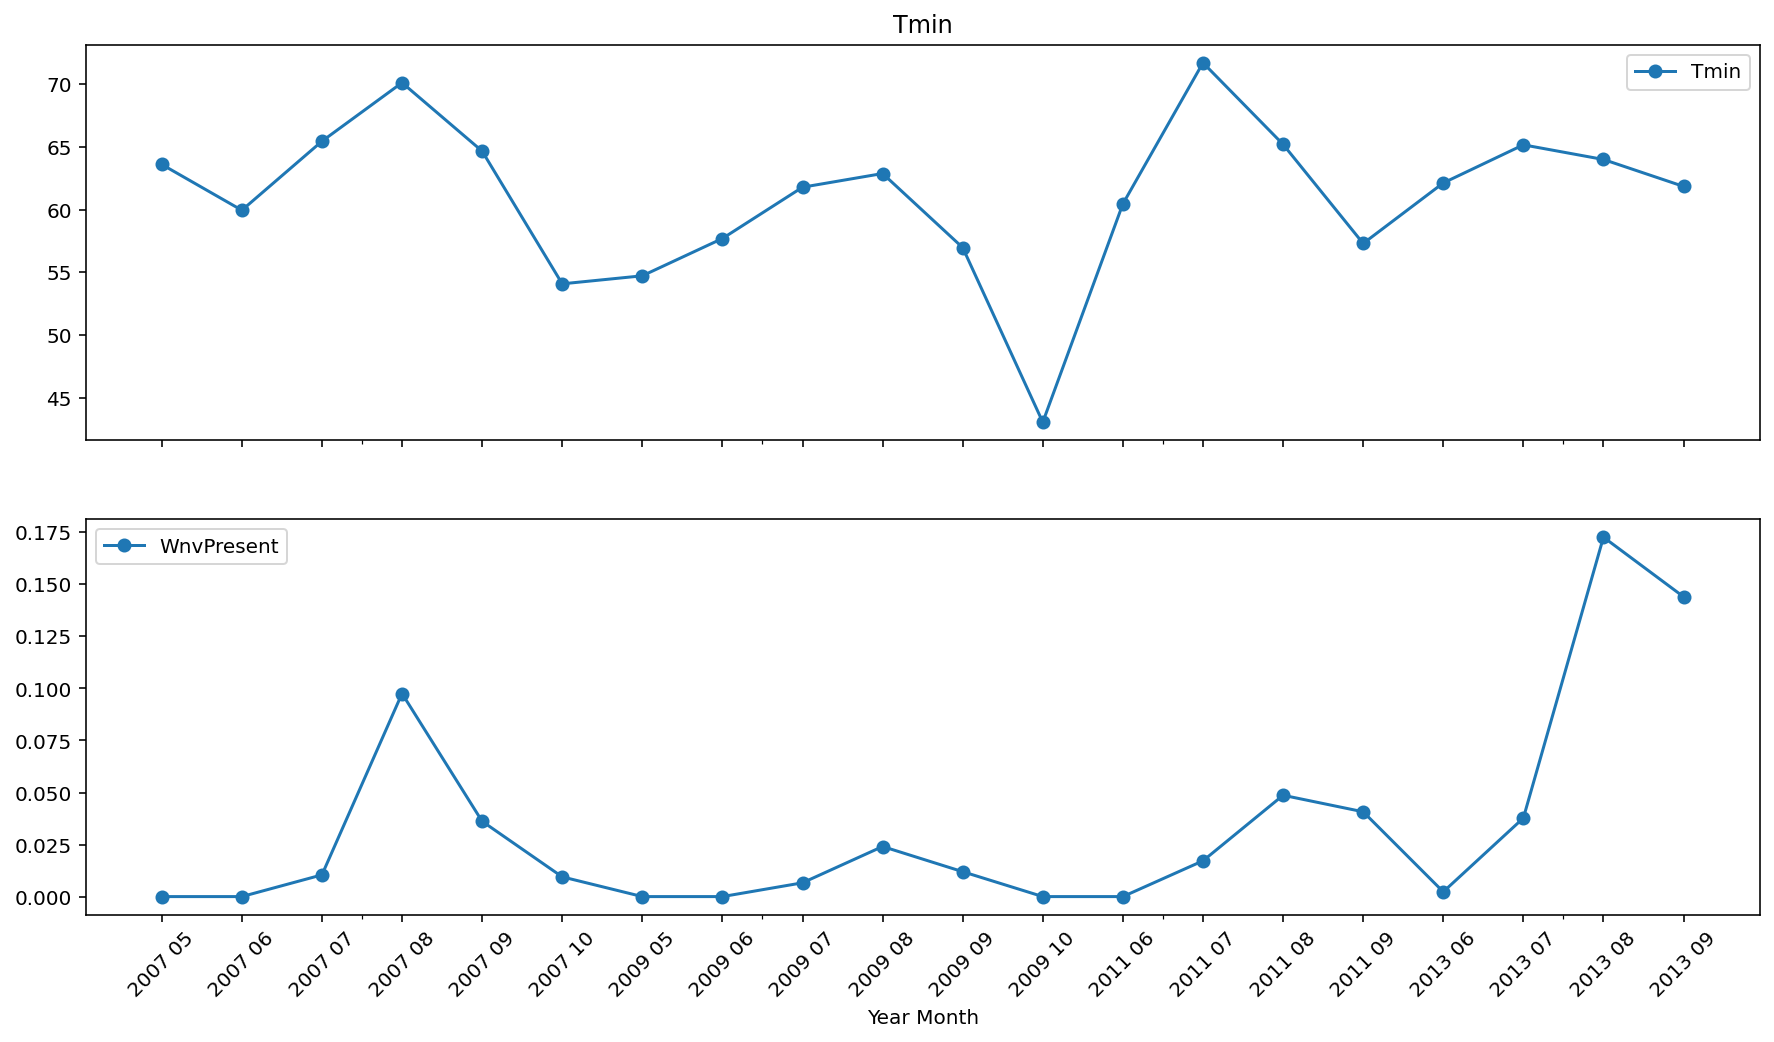

In [37]:
trend('Year Month')

### General observations
* There may be a lag effect in how weather variables could lead to a higher incidence of virus. For example, in 2011, when temperatures peaked in July, the number of cases of West Nile Virus (WNV) only peaked in August. 
* The higher the temperature/ total precipitation, the higher the incidence of WNV.
* Higher incidences of WNV correlated with lower atmospheric/barometric pressure (i.e. `SeaLevel`). This makes sense as lower barometric pressure will more likely lead to rainfall, which is conducive for mosquitos breeding and population growth.

### Seeing that some of the variables have a lagging effect on the growth of the mosquito population, we create lagged variables for the weather features so that the model can account for how the weather conditions in the previous month affect the incidences of the West Nile Virus today.

In [38]:
# create a function to transform the weather features to incorporate the lagging effects
def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Adding Year Month columns to aggregrate weather data by year and month
    weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
    # Adding this to use as key for lag variables
    df['Year Month L1'] = df['Date'] - pd.DateOffset(months=1)
    df['Year Month L1'] = df['Year Month L1'].dt.strftime('%Y %m')

    # Creating a temporary pivot table to extract weather states by year month
    pivot = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], 
                                        values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 'SeaLevel', 
                                                'AvgSpeed', 'RelativeHumidity'], aggfunc='mean').to_records())
    
    # Rename the columns in the pivot table
    old_col = pivot.drop('Station', axis='columns').columns
    new_col = old_col + "_"
    pivot = pivot.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from pivot
    for item in new_col[1:]:
        df = pivot[['Station', 'Year_Month_', item]].merge(df, 
                                                           how='right', left_on=['Station', 'Year_Month_'], 
                                                           right_on=['Station', 'Year Month'])  \
                                                                     .rename(columns={item: item + 'L0'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
        df = pivot[['Station', 'Year_Month_', item]].merge(df, how='right', 
                                                           left_on=['Station', 'Year_Month_'], 
                                                           right_on=['Station', 'Year Month L1'])  \
                                                                     .rename(columns={item: item + 'L1'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
    
    return df

In [39]:
# apply the function above to effect the data transformation
train_merged_df = add_weather_stats(train_merged_df)

In [40]:
print(train_merged_df.info())
train_merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Station              10506 non-null  int64         
 1   Tmin_L1              10422 non-null  float64       
 2   Tmin_L0              10506 non-null  float64       
 3   Tmax_L1              10422 non-null  float64       
 4   Tmax_L0              10506 non-null  float64       
 5   SeaLevel_L1          10422 non-null  float64       
 6   SeaLevel_L0          10506 non-null  float64       
 7   RelativeHumidity_L1  10422 non-null  float64       
 8   RelativeHumidity_L0  10506 non-null  float64       
 9   PrecipTotal_L1       10422 non-null  float64       
 10  PrecipTotal_L0       10506 non-null  float64       
 11  DewPoint_L1          10422 non-null  float64       
 12  DewPoint_L0          10506 non-null  float64       
 13  AvgSpeed_L1          10422 non-

Station  Tmin_L1    Tmin_L0  Tmax_L1    Tmax_L0  SeaLevel_L1  SeaLevel_L0  \
0        1      NaN  52.032258      NaN  75.516129          NaN    30.082258   
1        1      NaN  52.032258      NaN  75.516129          NaN    30.082258   
2        1      NaN  52.032258      NaN  75.516129          NaN    30.082258   
3        1      NaN  52.032258      NaN  75.516129          NaN    30.082258   
4        1      NaN  52.032258      NaN  75.516129          NaN    30.082258   

   RelativeHumidity_L1  RelativeHumidity_L0  PrecipTotal_L1  ...  Tavg  \
0                  NaN             53.24535             NaN  ...  74.0   
1                  NaN             53.24535             NaN  ...  74.0   
2                  NaN             53.24535             NaN  ...  74.0   
3                  NaN             53.24535             NaN  ...  74.0   
4                  NaN             53.24535             NaN  ...  74.0   

   DewPoint  PrecipTotal  StnPressure  SeaLevel AvgSpeed  Rain  Mist  \
0        58          0.0        29.39     30.11      6.5     0     1   
1        58          0.0        29.39     30.11      6.5     0     1   
2        58          0.0        29.39     30.11      6.5     0     1   
3        58          0.0        29.39     30.11      6.5     0     1   
4        58          0.0        29.39     30.11      6.5     0     1   

   RelativeHumidity Year Month L1  
0         57.368792       2007 04  
1         57.368792       2007 04  
2         57.368792       2007 04  
3         57.368792       2007 04  
4         57.368792       2007 04  

[5 rows x 38 columns]

In [41]:
# merge only values that contain no missing values 
train_merged_df = train_merged_df[(train_merged_df['Year Month'] != '2007 05') & (train_merged_df['Year Month'] != '2009 05')]
train_merged_df = train_merged_df.drop(['Year Month', 'Year Month L1', 'Station', 'Date'], axis='columns')
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10422 entries, 25 to 10505
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tmin_L1              10422 non-null  float64
 1   Tmin_L0              10422 non-null  float64
 2   Tmax_L1              10422 non-null  float64
 3   Tmax_L0              10422 non-null  float64
 4   SeaLevel_L1          10422 non-null  float64
 5   SeaLevel_L0          10422 non-null  float64
 6   RelativeHumidity_L1  10422 non-null  float64
 7   RelativeHumidity_L0  10422 non-null  float64
 8   PrecipTotal_L1       10422 non-null  float64
 9   PrecipTotal_L0       10422 non-null  float64
 10  DewPoint_L1          10422 non-null  float64
 11  DewPoint_L0          10422 non-null  float64
 12  AvgSpeed_L1          10422 non-null  float64
 13  AvgSpeed_L0          10422 non-null  float64
 14  WnvPresent           10422 non-null  int64  
 15  Month                10422 non-null

## B. Model Preparation

### 1. Create features matrix (X) & target vector (y)

In [42]:
# create features matrix (X)
X = train_merged_df.drop(["WnvPresent"], axis=1)

# create target vector (y)
y = train_merged_df["WnvPresent"]

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10422 entries, 25 to 10505
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tmin_L1              10422 non-null  float64
 1   Tmin_L0              10422 non-null  float64
 2   Tmax_L1              10422 non-null  float64
 3   Tmax_L0              10422 non-null  float64
 4   SeaLevel_L1          10422 non-null  float64
 5   SeaLevel_L0          10422 non-null  float64
 6   RelativeHumidity_L1  10422 non-null  float64
 7   RelativeHumidity_L0  10422 non-null  float64
 8   PrecipTotal_L1       10422 non-null  float64
 9   PrecipTotal_L0       10422 non-null  float64
 10  DewPoint_L1          10422 non-null  float64
 11  DewPoint_L0          10422 non-null  float64
 12  AvgSpeed_L1          10422 non-null  float64
 13  AvgSpeed_L0          10422 non-null  float64
 14  Month                10422 non-null  int64  
 15  Week                 10422 non-null

In [44]:
# Do a train-test split of 70-30 for train-test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,stratify=y, random_state=42)

In [45]:
# Print the shape of train and test to ensure the split is 70-30
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7295, 33)
(3127, 33)
(7295,)
(3127,)


### 2. Check if it would be useful if we included polynomial features for non-linear relationships

In [46]:
# generates the full polynomial feature table
pf = PolynomialFeatures(include_bias=False, degree=2)
X_train_pf = pf.fit_transform(X_train)

# Adds appropriate feature names to all polynomial features
X_train_pf = pd.DataFrame(X_train_pf,columns=pf.get_feature_names(X_train.columns))
print(X_train_pf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Columns: 594 entries, Tmin_L1 to RelativeHumidity^2
dtypes: float64(594)
memory usage: 33.1 MB
None


In [47]:
# Generates list of poly feature correlations
corr = X_train_pf.corrwith(y_train)

poly_feat = corr[(corr.notnull()) & (abs(corr) >= 0.5)].sort_values(ascending=False).index.tolist()
poly_feat

[]

In [48]:
abs(corr).max()

0.03215785311304827

None of the polynomial features have absolute correlation stronger than 0.5 with the target variable. The maximum absolute correlation is only 0.3216, implying a relatively weak correlation with target. Since the polynomial features have weak correlation with target, we will not apply polynomial features within our model.

### 3. Addressing the target class imbalance using SMOTE sampling
SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that generates synthetic samples from the minority class. It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [49]:
# show class imbalance
print(y_train.value_counts(normalize=True))

0    0.947087
1    0.052913
Name: WnvPresent, dtype: float64


In [50]:
# create function to run model with standard scaling, SMOTE sampling, 
# with an option to run grid search, model and print results

def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
    else:
        pipe.fit(X_train, y_train)
        

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    auc_scores = cross_val_score(pipe, X_train, y_train,  scoring='roc_auc', cv = 5)

    results['model'] = mod
    
    results['train_auc_cv'] = auc_scores.mean()
    
    results['f1'] = f1_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)        # % OF ACTUAL positives that are CORRECTLY predicted
    results['precision'] = precision_score(y_test, predictions)  # % OF positives that are CORRECTLY predicted

    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['auc_diff'] = results['train_auc'] - results['test_auc']

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)

    return pipe

In [51]:
X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()


# create loop to run SMOTE sampling and compare the modelling outcomes with and without it
for k in ['No', 'SMOTE']:
    print('\nMethod Used: {}'.format(k + ' sampling'), "-" * 100)
        
    print('\nClass Balance BEFORE')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]))
  
    # instiantiate the models
    methods = {'SMOTE': SMOTE(random_state=42)}
    
    if k == 'SMOTE':
        mthd = methods[k]
        X_train, y_train = mthd.fit_resample(X_train, y_train)

    print('\nClass Balance AFTER')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]),'\n')
    
    
    # Instiantiate models
    models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
              'rf': RandomForestClassifier(random_state=42),
              'gb': GradientBoostingClassifier(random_state=42),
              'dt': DecisionTreeClassifier(random_state=42),
              'et': ExtraTreesClassifier(random_state=42),
              'ada': AdaBoostClassifier(random_state=42),
              'svc': SVC(random_state=42, probability=True),
            }

    # Instantiate lists to store results
    init_list = []
    gs_list = []

    for m in models:
        run_model(m)
    result_df = pd.DataFrame(init_list).sort_values(by=["f1"], ascending=False).reset_index(drop=True)
    display(result_df)

    X_train = X_train_copy
    y_train = y_train_copy


Method Used: No sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0    0.947087
1    0.052913
Name: WnvPresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0    0.947087
1    0.052913
Name: WnvPresent, dtype: float64

Number of rows: 7295 



C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model  train_auc_cv        f1    recall  precision  train_auc  test_auc  \
0    rf      0.767563  0.107143  0.072727    0.20339   0.943761  0.749228   
1    dt      0.734981  0.104265  0.066667    0.23913   0.944540  0.710449   
2    et      0.734896  0.102804  0.066667    0.22449   0.944540  0.708432   
3    lr      0.832778  0.000000  0.000000    0.00000   0.843867  0.813177   
4    gb      0.855704  0.000000  0.000000    0.00000   0.902317  0.848950   
5   ada      0.850752  0.000000  0.000000    0.00000   0.879293  0.839028   
6   svc      0.755371  0.000000  0.000000    0.00000   0.840362  0.747608   

   auc_diff  
0  0.194533  
1  0.234092  
2  0.236108  
3  0.030690  
4  0.053367  
5  0.040265  
6  0.092754


Method Used: SMOTE sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0.0    0.947087
1.0    0.052913
Name: WnvPresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: WnvPresent, dtype: float64

Number of rows: 13818 



model  train_auc_cv        f1    recall  precision  train_auc  test_auc  \
0    gb      0.976043  0.309609  0.527273   0.219144   0.978288  0.837721   
1   ada      0.962699  0.307220  0.606061   0.205761   0.963814  0.837294   
2   svc      0.955815  0.285714  0.636364   0.184211   0.962178  0.828141   
3    rf      0.978472  0.249423  0.327273   0.201493   0.988925  0.748130   
4    et      0.975039  0.248244  0.321212   0.202290   0.989727  0.707890   
5    dt      0.973889  0.247086  0.321212   0.200758   0.989727  0.712486   
6    lr      0.858475  0.228873  0.787879   0.133883   0.861275  0.815409   

   auc_diff  
0  0.140567  
1  0.126520  
2  0.134037  
3  0.240795  
4  0.281837  
5  0.277241  
6  0.045865

Based on the metric scores in the tables above, the SMOTE sampling proved to be superior to not doing any sampling of the data with a strong class imbalance. We proceed to select and evaluate the models based on the scores generated using SMOTE sampling.

## C. Model Selection & Evaluation

We select the best model based on the following metrics:
- cross-validated ROC AUC score; 
- recall score; and 
- precision score.

### The AdaBoosting Classifier performed the best.

Although the Gradient Boosting model has the strongest ROC AUC score, its recall score (0.527) pales in comparison to that of Adaboost (0.606). This means that we are likely to have fewer False Negatives using Adaboost. 

Support Vector Classification is also a possible consideration, but it fared worse in terms of the ROC AUC score and precision score compared to Adaboost.

AdaBoost seems like the best model for this use case as it is important to ensure a relatively high recall score that does not overly compromise the ROC AUC and precision score. 

In [52]:
print('\nClass Balance BEFORE')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]))

# instiantiate the SMOTE sampling method 
sm = SMOTE(random_state=42)  
X_train, y_train = sm.fit_resample(X_train, y_train)

print('\nClass Balance AFTER')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]),'\n')

# instantiate lists to store results
gs_list = []

# run the gridsearch using the function that was defined earlier
ada_best = run_model('ada', 
          mod_params={
              'ada__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
              'ada__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'ada__algorithm' :['SAMME', 'SAMME.R']
          },
          grid_search=True)
    
X_train = X_train_copy
y_train = y_train_copy    


Class Balance BEFORE


0.0    0.947087
1.0    0.052913
Name: WnvPresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: WnvPresent, dtype: float64

Number of rows: 13818 

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
### BEST PARAMS ###


{'ada__algorithm': 'SAMME.R',
 'ada__learning_rate': 1,
 'ada__n_estimators': 200}

### The key metric scores of the chosen AdaBoosting Classifier model are summarised below:

In [53]:
ada_result_df = pd.DataFrame(gs_list).reset_index(drop=True)
display(ada_result_df)

model  train_auc_cv        f1    recall  precision  train_auc  test_auc  \
0   ada      0.973101  0.285211  0.490909   0.200993   0.974507  0.843019   

   auc_diff  
0  0.131489

In [54]:
# create a function to plot the confusion matrix

def plot_confusion_matrix(y_test, test_preds):
    cm = confusion_matrix(y_test, test_preds)
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

    TN, FP, FN, TP = cm.ravel()

    print("Precison: {:.3f} (TP / (TP + FP))".format(TP / (TP + FP)))
    print("Recall: {:.3f} (TP / (TP + FN))".format(TP / (TP + FN)))
    print("F1 Score: {:.3f} (2*TP / (2*TP + FN + FP))".format(2*TP / (2*TP + FN + FP)), '\n')
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=np.array(modified_cm),
                fmt="",
                annot_kws={"size": 10},
                linewidths=.5,
                square = True,
                cmap = 'Blues',
                xticklabels = ['Virus Absent', 'Virus Present'],
                yticklabels = ['Virus Absent', 'Virus Present'],
                )

    plt.ylabel('Actual', fontsize = 10);
    plt.xlabel('Predicted', fontsize = 10);
    plt.title('Confusion Matrix of Predictions Made by \n AdaBoosting Classifier', 
          fontweight='bold', fontsize=10);
    plt.tick_params(labelsize= 8)

In [55]:
# show the best parameters for AdaBoosting
ada_best.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('ada',
                 AdaBoostClassifier(learning_rate=1, n_estimators=200,
                                    random_state=42))])

In [56]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of WNV)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(ada_best.best_estimator_.named_steps["ada"].feature_importances_),
                            columns=['Importances']) 
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
df = pd.concat([features, coefficients], axis='columns').sort_values('Importances', ascending=False)
df

Features  Importances
17             RESTUANS        0.165
20       WnvRisk_medium        0.105
16              PIPIENS        0.075
24                 Tavg        0.065
21         WnvRisk_high        0.065
19          WnvRisk_low        0.065
15                 Week        0.045
23                 Tmin        0.040
29             AvgSpeed        0.035
12          AvgSpeed_L1        0.030
25             DewPoint        0.030
32     RelativeHumidity        0.030
9        PrecipTotal_L0        0.030
4           SeaLevel_L1        0.030
5           SeaLevel_L0        0.020
31                 Mist        0.020
2               Tmax_L1        0.020
26          PrecipTotal        0.020
6   RelativeHumidity_L1        0.020
0               Tmin_L1        0.015
10          DewPoint_L1        0.015
27          StnPressure        0.015
22                 Tmax        0.010
7   RelativeHumidity_L0        0.010
1               Tmin_L0        0.010
13          AvgSpeed_L0        0.005
18     WnvRisk_very low        0.005
28             SeaLevel        0.005
3               Tmax_L0        0.000
8        PrecipTotal_L1        0.000
30                 Rain        0.000
14                Month        0.000
11          DewPoint_L0        0.000

Precison: 0.201 (TP / (TP + FP))
Recall: 0.491 (TP / (TP + FN))
F1 Score: 0.285 (2*TP / (2*TP + FN + FP)) 



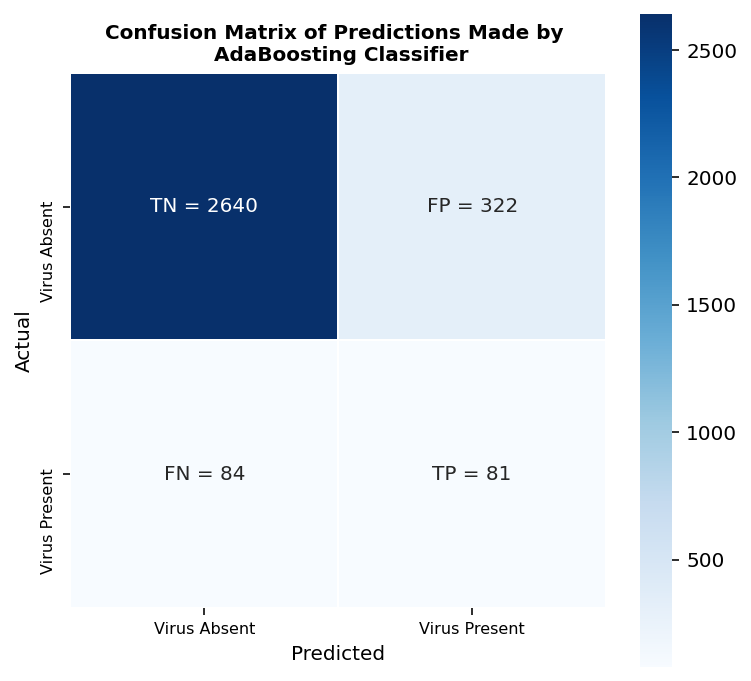

In [57]:
# plot confusion matrix
plot_confusion_matrix(y_test, ada_best.best_estimator_.predict(X_test))

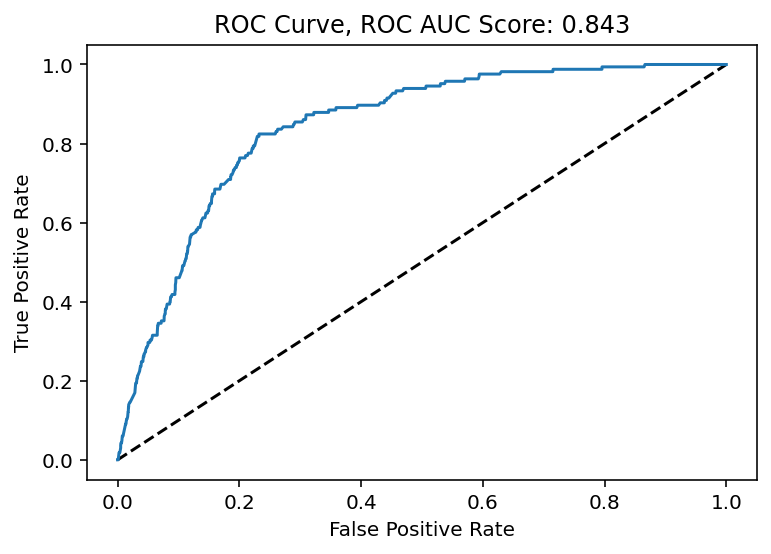

In [58]:
y_pred_prob = ada_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_prob).round(3)))
plt.show()

### Import the test dataset for model testing

In [59]:
# import cleaned datasets/ original Kaggle datasets 
test = pd.read_csv("../assets/test.csv", parse_dates=[1])
weather = pd.read_csv("../assets/weather_cleaned.csv", parse_dates=[1])

In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [61]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Station           2944 non-null   int64         
 1   Date              2944 non-null   datetime64[ns]
 2   Tmax              2944 non-null   int64         
 3   Tmin              2944 non-null   int64         
 4   Tavg              2944 non-null   float64       
 5   DewPoint          2944 non-null   int64         
 6   PrecipTotal       2944 non-null   float64       
 7   StnPressure       2944 non-null   float64       
 8   SeaLevel          2944 non-null   float64       
 9   AvgSpeed          2944 non-null   float64       
 10  Rain              2944 non-null   int64         
 11  Mist              2944 non-null   int64         
 12  RelativeHumidity  2944 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 299.1 KB


### Set up preprocessing functions

In [62]:
def assign_station(lat:int, lng:int) -> int:
    coord_stn1 = (41.995, -87.933)
    coord_stn2 = (41.786, -87.752)
    coord_curr = (lat, lng)
    return 1 if geodesic(coord_curr, coord_stn1) < geodesic(coord_curr, coord_stn2) else 2

def clean_data(data:pd.DataFrame, weather)-> pd.DataFrame:
    data['Station'] = data.apply(lambda x: assign_station(x['Latitude'], x['Longitude']), axis=1)
      
    # merging 2 datasets into 1
    df = data.merge(weather, how='left', on=['Date', 'Station'])
    return df
    
def add_date_features(df:pd.DataFrame) -> pd.DataFrame:
    if df.index.inferred_type != "datetime64":
        df = df.set_index('Date')
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Year Month'] = df.index.strftime('%Y %m')
    df['Year Month L1'] = df.index.date - pd.DateOffset(months=1)
    df['Year Month L1'] = df['Year Month L1'].dt.strftime('%Y %m')
    return df


def add_species_features(df:pd.DataFrame) -> pd.DataFrame:
    df['RESTUANS'] = np.where(df['Species'].str.lower().str.contains('restuans'), 1, 0)
    df['PIPIENS'] = np.where(df['Species'].str.lower().str.contains('pipiens'), 1, 0)
    df = df.drop(['Species'], axis='columns')
    return df

def add_weather_features(df:pd.DataFrame) -> pd.DataFrame:
    try:
        df['Rain'] = np.where(df['CodeSum'].str.contains('|'.join(['TS', 'RA', 'DZ', 'SH', 'SQ'])), 1, 0)
        df['Mist'] = np.where(df['CodeSum'].str.contains('|'.join(['BR', 'HZ', 'FG', 'FU'])), 1, 0)
        df = df.drop(['CodeSum'], axis='columns')
    except:
        return df
    return df

def add_location_features(df:pd.DataFrame) -> pd.DataFrame:
    df = wnv_risk.reset_index()[['AddressNumberAndStreet', 'WNV_risk']].merge(df, 
                                                                              how='right', on='AddressNumberAndStreet') # add risk level column
    df = pd.get_dummies(df, columns=['WNV_risk'], prefix='WnvRisk')

    return df

def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Adding Year Month columns to aggregrate weather data by year and month
    weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
    # Creating a temporary pivot table to extract weather states by year month
    temp_df = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], 
                                          values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 
                                                  'SeaLevel', 'AvgSpeed', 'RelativeHumidity'], 
                                          aggfunc='mean').to_records())
    
    # Rename temp_df columns
    old_col = temp_df.drop('Station', axis='columns').columns
    new_col = old_col + "_"
    temp_df = temp_df.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from temp_df
    for item in new_col[1:]:
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', 
                                                             left_on=['Station', 'Year_Month_'], 
                                                             right_on=['Station', 'Year Month'])  \
                                                                     .rename(columns={item: item + 'L0'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', 
                                                             left_on=['Station', 'Year_Month_'], 
                                                             right_on=['Station', 'Year Month L1'])  \
                                                                     .rename(columns={item: item + 'L1'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
    return df

def cleanup(df):
    df = df[(df['Year Month'] != '2007 05') & (df['Year Month'] != '2009 05')]
    df = df.drop(['Year Month', 'Year Month L1', 'AddressNumberAndStreet', 'Address', 
                  'Block', 'Street', 'Trap', 'AddressAccuracy', 'Station'], axis='columns')
    return df


def predict(df):
    df_id = df['Id']

    df_base = df.drop(['Latitude','Longitude', 'Id'], axis='columns')
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['WNVPresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba(df):
    df_coord = df[['Latitude', 'Longitude']]
    
    df_base = df.drop(['Latitude','Longitude', 'Id'], axis='columns')
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [63]:
# apply the preprocessing functions on the test data
test_data = test.pipe(clean_data, weather) \
             .pipe(add_date_features) \
             .pipe(add_species_features) \
             .pipe(add_weather_features) \
             .pipe(add_location_features) \
             .pipe(add_weather_stats)  \
             .pipe(cleanup) 

test_data.info()

assert test_data.isnull().sum().sum() == 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Tmin_L1              116293 non-null  float64
 1   Tmin_L0              116293 non-null  float64
 2   Tmax_L1              116293 non-null  float64
 3   Tmax_L0              116293 non-null  float64
 4   SeaLevel_L1          116293 non-null  float64
 5   SeaLevel_L0          116293 non-null  float64
 6   RelativeHumidity_L1  116293 non-null  float64
 7   RelativeHumidity_L0  116293 non-null  float64
 8   PrecipTotal_L1       116293 non-null  float64
 9   PrecipTotal_L0       116293 non-null  float64
 10  DewPoint_L1          116293 non-null  float64
 11  DewPoint_L0          116293 non-null  float64
 12  AvgSpeed_L1          116293 non-null  float64
 13  AvgSpeed_L0          116293 non-null  float64
 14  Id                   116293 non-null  int64  
 15  Latitude         

In [64]:
test_data.head()

Tmin_L1  Tmin_L0   Tmax_L1    Tmax_L0  SeaLevel_L1  SeaLevel_L0  \
0  44.83871     60.7  66.16129  80.866667    29.864194    29.878333   
1  44.83871     60.7  66.16129  80.866667    29.864194    29.878333   
2  44.83871     60.7  66.16129  80.866667    29.864194    29.878333   
3  44.83871     60.7  66.16129  80.866667    29.864194    29.878333   
4  44.83871     60.7  66.16129  80.866667    29.864194    29.878333   

   RelativeHumidity_L1  RelativeHumidity_L0  PrecipTotal_L1  PrecipTotal_L0  \
0            61.476124            62.964004        0.132258        0.139333   
1            61.476124            62.964004        0.132258        0.139333   
2            61.476124            62.964004        0.132258        0.139333   
3            61.476124            62.964004        0.132258        0.139333   
4            61.476124            62.964004        0.132258        0.139333   

   ...  Mist  RelativeHumidity  Month  Week  RESTUANS  PIPIENS  \
0  ...     0         54.279197      6    24         1        1   
1  ...     0         54.279197      6    24         1        0   
2  ...     0         54.279197      6    24         0        1   
3  ...     0         54.279197      6    24         0        0   
4  ...     0         54.279197      6    24         0        0   

   WnvRisk_very low  WnvRisk_low  WnvRisk_medium  WnvRisk_high  
0                 0            0               0             1  
1                 0            0               0             1  
2                 0            0               0             1  
3                 0            0               0             1  
4                 0            0               0             1  

[5 rows x 36 columns]

In [65]:
# generate predictions
pred = predict(test_data)
pred

Id  WNVPresent
0            1         0.0
1            2         0.0
2            3         0.0
3            4         0.0
4            5         0.0
...        ...         ...
116288  116289         0.0
116289  116290         0.0
116290  116291         0.0
116291  116292         0.0
116292  116293         0.0

[116293 rows x 2 columns]

In [66]:
# generate prediction probabilities 
pred_probability = predict_proba(test_data)
pred_probability

Latitude  Longitude         0         1
0       41.954690 -87.800991  0.643516  0.356484
1       41.954690 -87.800991  0.643516  0.356484
2       41.954690 -87.800991  0.643516  0.356484
3       41.954690 -87.800991  0.643516  0.356484
4       41.954690 -87.800991  0.643516  0.356484
...           ...        ...       ...       ...
116288  41.925652 -87.633590  0.639320  0.360680
116289  41.925652 -87.633590  0.639320  0.360680
116290  41.925652 -87.633590  0.639320  0.360680
116291  41.925652 -87.633590  0.639320  0.360680
116292  41.925652 -87.633590  0.639320  0.360680

[116293 rows x 4 columns]

In [67]:
# export predictions to csv
pred.to_csv('../kaggle/submission.csv', index=False)
pred_probability.to_csv('../assets/prediction_probability_with_traps.csv', index=False)